In [6]:
import numpy as np

def make_monotonic(column_name, df):
    prev = df.loc[0, (column_name)]
    for i in range(1, len(df[column_name])):
        curr = df.loc[i, (column_name)]
        if curr < prev:
            df.loc[i, (column_name)] = prev
        prev = df.loc[i, (column_name)]

def add_trailing_zeros(labels):
    for i, label in enumerate(labels):
        if len(label) < 6:
            zeros = (6 - len(label))* '0' 
            labels[i] = label + zeros
    return labels
        
def calc_avg_clients_metrics(clients_metrics):
    avg_acc = 0
    avg_prec = 0
    avg_rec = 0
    avg_fscore = 0
    avg_loss = 0

    accuracies = []

    for client_metrics in clients_metrics:
        avg_acc += client_metrics["accuracy"]
        avg_prec += client_metrics["precision"]
        avg_rec += client_metrics["recall"]
        avg_fscore += client_metrics["f1"]
        avg_loss += client_metrics["loss"]
        accuracies.append(client_metrics["accuracy"])
    
    nr_clients = len(clients_metrics)
    avg_acc /= nr_clients
    avg_prec /= nr_clients
    avg_rec /= nr_clients
    avg_fscore /= nr_clients
    avg_loss /= nr_clients
    std = np.std(accuracies)

    return {
        'average_accuracy': avg_acc,
        'average_precision': avg_prec,
        'average_recall': avg_rec,
        'average_fscore': avg_fscore,
        'average_loss': avg_loss,
        'upper_2std': 2*std+avg_acc,
        'lower_2std': avg_acc-2*std,
        'std': std,
    }


# Key: C
# Value: per client communication
# when reached 97%
def get_metrics_fedavg(client_e, comm_rounds, iid):
    reach_threshhold = {'C': [], 'sent_models_per_client': [], 'network_load': [], 'comm_round': []}
    C_all=[1, 10, 20, 50, 100]
    for C in C_all:
        nr_clients = 100 ### NUMBER OF CLIENTS/ENTITIES
        
        client_epochs = client_e   # Number of client epochs
        if client_epochs == 1 and C == 1 and not iid:
            communication_rounds = 4000 
        else:
            communication_rounds = comm_rounds  # Number of maximum communication rounds
        test_every_x_round = 1

        dir_str = '{}_{}_{}_{}_{}/'.format(nr_clients, C, client_epochs, communication_rounds, test_every_x_round)

        if iid:
            path = './Results/Fedavg_iid/' + dir_str
        else:
            path = './Results/Fedavg_non_iid/' + dir_str

        with open(path + 'metrics', 'rb') as metrics_file:
            metrics = pickle.load(metrics_file)

        # per node communication
        # C*nr_clients*round
        all_rounds = metrics[0]
        # Find when acc bigger than 97%
        for i, test_round in enumerate(all_rounds):
            if test_round['accuracy'] >= 0.97:
                reach_threshhold['C'].append(C/100)
                reach_threshhold['sent_models_per_client'].append((i+1)*test_every_x_round*C/nr_clients)
                reach_threshhold['comm_round'].append((i+1)*test_every_x_round)
                reach_threshhold['network_load'].append((i+1)* test_every_x_round*nr_clients*(C/nr_clients) + nr_clients)
                break
    return reach_threshhold

def get_metrics_p2p(client_e, comm_rounds, iid):
    C_all=[1, 2, 5, 10, 20, 50, 99]
    reach_threshhold = {'C': [], 'sent_models_per_client': [], 'network_load': [], 'comm_round': []}
    for C in C_all:
        nr_clients = 100 ### NUMBER OF CLIENTS/ENTITIES
        
        client_epochs = client_e   # Number of client epochs
        communication_rounds = comm_rounds  # Number of maximum communication rounds
        test_every_x_round = 10

        dir_str = '{}_{}_{}_{}_{}/'.format(nr_clients, C, client_epochs, communication_rounds, test_every_x_round)
        if iid:
            path = './Results/P2P_iid/' + dir_str
        else:
            path = './Results/P2P_non_iid/' + dir_str

        with open(path + 'metrics', 'rb') as metrics_file:
            metrics_p2p = pickle.load(metrics_file)

        avgs =  [calc_avg_clients_metrics(metrics_p2p[0][i]) for i in range(communication_rounds//test_every_x_round)]
        #print(avgs)
        # per node communication
        # C*nr_clients*round
        # Find when acc bigger than 97%
        for i, test_round in enumerate(avgs):
            #
            if test_round['average_accuracy'] >= 0.97:
                #print(test_round)
                #print(i)
                if C == 99:
                    reach_threshhold['C'].append(1)
                else:
                    reach_threshhold['C'].append(C/100)
                reach_threshhold['sent_models_per_client'].append((i+1)*test_every_x_round*C)
                reach_threshhold['comm_round'].append((i+1)*test_every_x_round)
                reach_threshhold['network_load'].append((i+1)* test_every_x_round*nr_clients*C)
                break
    return reach_threshhold

def get_metrics_p2p_heur(client_e, comm_rounds, iid):
    #C_all=[1, 2, 5, 10, 20, 50, 99]
    C_all=[1, 2, 5, 10, 20, 50, 99]
    reach_threshhold = {'C': [], 'sent_models_per_client': [], 'network_load': [], 'comm_round': []}
    for C in C_all:
        nr_clients = 100 ### NUMBER OF CLIENTS/ENTITIES
        
        client_epochs = client_e   # Number of client epochs
        communication_rounds = comm_rounds  # Number of maximum communication rounds
        test_every_x_round = 10

        dir_str = '{}_{}_{}_{}_{}/'.format(nr_clients, C, client_epochs, communication_rounds, test_every_x_round)
        if iid:
            path = './Results/P2P_heur_iid/' + dir_str
        else:
            path = './Results/P2P_heur_non_iid/' + dir_str

        with open(path + 'metrics', 'rb') as metrics_file:
            metrics_p2p = pickle.load(metrics_file)

        avgs =  [calc_avg_clients_metrics(metrics_p2p[0][i]) for i in range(communication_rounds//test_every_x_round)]
        #print(avgs)
        # per node communication
        # C*nr_clients*round
        # Find when acc bigger than 97%
        for i, test_round in enumerate(avgs):
            #
            if test_round['average_accuracy'] >= 0.97:
                #print(test_round)
                #print(i)
                if C == 99:
                    reach_threshhold['C'].append(1)
                else:
                    reach_threshhold['C'].append(C/100)
                reach_threshhold['sent_models_per_client'].append((i+1)*test_every_x_round*C)
                reach_threshhold['comm_round'].append((i+1)*test_every_x_round)
                reach_threshhold['network_load'].append((i+1)* test_every_x_round*nr_clients*C)
                break
    return reach_threshhold

def get_metrics_p2p_acc(client_e, comm_rounds, iid):
    C_all=[1, 2, 5, 10, 20, 50, 99]
    #C_all=[1, 2, 5, 10]
    reach_threshhold = {'C': [], 'sent_models_per_client': [], 'network_load': [], 'comm_round': []}
    for C in C_all:
        nr_clients = 100 ### NUMBER OF CLIENTS/ENTITIES
        
        client_epochs = client_e   # Number of client epochs
        communication_rounds = comm_rounds  # Number of maximum communication rounds
        test_every_x_round = 10

        dir_str = '{}_{}_{}_{}_{}/'.format(nr_clients, C, client_epochs, communication_rounds, test_every_x_round)
        if iid:
            path = './Results/P2P_acc_iid/' + dir_str
        else:
            path = './Results/P2P_acc_non_iid/' + dir_str

        with open(path + 'metrics', 'rb') as metrics_file:
            metrics_p2p = pickle.load(metrics_file)

        avgs =  [calc_avg_clients_metrics(metrics_p2p[0][i]) for i in range(communication_rounds//test_every_x_round)]
        #print(avgs)
        # per node communication
        # C*nr_clients*round
        # Find when acc bigger than 97%
        for i, test_round in enumerate(avgs):
            #
            if test_round['average_accuracy'] >= 0.97:
                #print(test_round)
                #print(i)
                if C == 99:
                    reach_threshhold['C'].append(1)
                else:
                    reach_threshhold['C'].append(C/100)
                reach_threshhold['sent_models_per_client'].append((i+1)*test_every_x_round*C)
                reach_threshhold['comm_round'].append((i+1)*test_every_x_round)
                reach_threshhold['network_load'].append((i+1)* test_every_x_round*nr_clients*C)
                break
    return reach_threshhold

def get_metrics_p2p_acc_fix(client_e, comm_rounds, iid):
    C_all=[1, 2, 5, 10, 20, 50, 99]
    #C_all=[1, 2, 5, 10]
    reach_threshhold = {'C': [], 'sent_models_per_client': [], 'network_load': [], 'comm_round': []}
    for C in C_all:
        nr_clients = 100 ### NUMBER OF CLIENTS/ENTITIES
        
        client_epochs = client_e   # Number of client epochs
        communication_rounds = comm_rounds  # Number of maximum communication rounds
        test_every_x_round = 10

        dir_str = '{}_{}_{}_{}_{}/'.format(nr_clients, C, client_epochs, communication_rounds, test_every_x_round)
        if iid:
            path = './Results/P2P_acc_iid/' + dir_str
        else:
            path = './Results/P2P_acc_non_iid_2/' + dir_str

        with open(path + 'metrics', 'rb') as metrics_file:
            metrics_p2p = pickle.load(metrics_file)

        avgs =  [calc_avg_clients_metrics(metrics_p2p[0][i]) for i in range(communication_rounds//test_every_x_round)]
        #print(avgs)
        # per node communication
        # C*nr_clients*round
        # Find when acc bigger than 97%
        for i, test_round in enumerate(avgs):
            #
            if test_round['average_accuracy'] >= 0.97:
                #print(test_round)
                #print(i)
                if C == 99:
                    reach_threshhold['C'].append(1)
                else:
                    reach_threshhold['C'].append(C/100)
                reach_threshhold['sent_models_per_client'].append((i+1)*test_every_x_round*C)
                reach_threshhold['comm_round'].append((i+1)*test_every_x_round)
                reach_threshhold['network_load'].append((i+1)* test_every_x_round*nr_clients*C)
                break
    return reach_threshhold


def get_metrics_p2p_cos(client_e, comm_rounds, iid):
    C_all=[1, 2, 5, 10, 20, 50, 99]
    #C_all=[1, 2, 5, 10]
    reach_threshhold = {'C': [], 'sent_models_per_client': [], 'network_load': [], 'comm_round': []}
    for C in C_all:
        nr_clients = 100 ### NUMBER OF CLIENTS/ENTITIES
        
        client_epochs = client_e   # Number of client epochs
        communication_rounds = comm_rounds  # Number of maximum communication rounds
        test_every_x_round = 10

        dir_str = '{}_{}_{}_{}_{}/'.format(nr_clients, C, client_epochs, communication_rounds, test_every_x_round)
        if iid:
            path = './Results/P2P_cosine_iid/' + dir_str
        else:
            path = './Results/P2P_cosine_non_iid/' + dir_str

        with open(path + 'metrics', 'rb') as metrics_file:
            metrics_p2p = pickle.load(metrics_file)

        avgs =  [calc_avg_clients_metrics(metrics_p2p[0][i]) for i in range(communication_rounds//test_every_x_round)]
        #print(avgs)
        # per node communication
        # C*nr_clients*round
        # Find when acc bigger than 97%
        for i, test_round in enumerate(avgs):
            #
            if test_round['average_accuracy'] >= 0.97:
                #print(test_round)
                #print(i)
                if C == 99:
                    reach_threshhold['C'].append(1)
                else:
                    reach_threshhold['C'].append(C/100)
                reach_threshhold['sent_models_per_client'].append((i+1)*test_every_x_round*C)
                reach_threshhold['comm_round'].append((i+1)*test_every_x_round)
                reach_threshhold['network_load'].append((i+1)* test_every_x_round*nr_clients*C)
                break
    return reach_threshhold

No handles with labels found to put in legend.


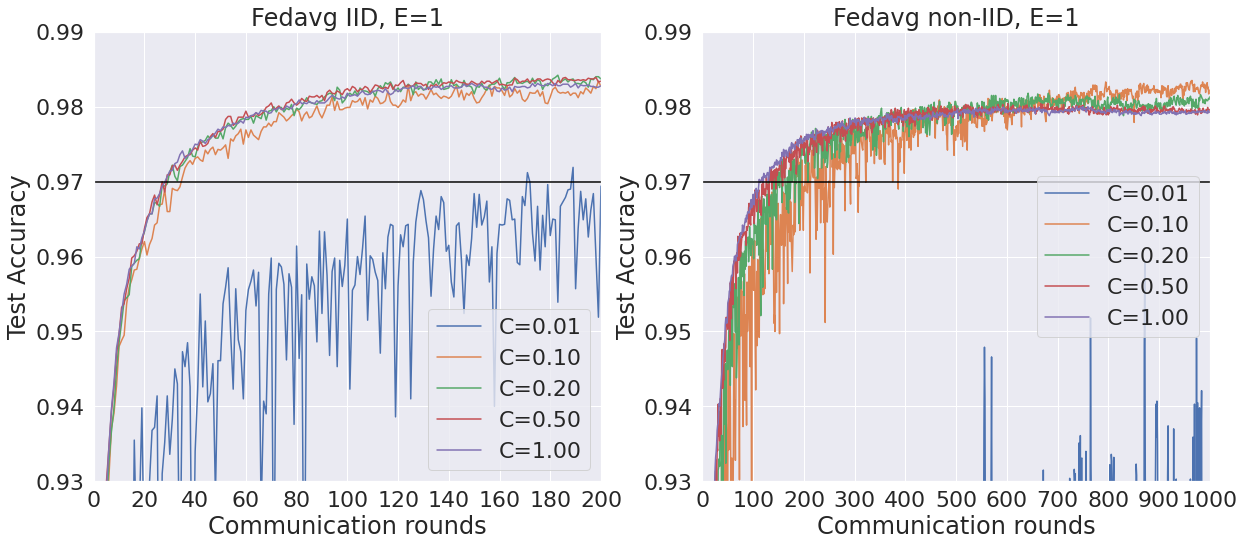

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import matplotlib.ticker as ticker
sns.set_theme(style="darkgrid")
sns.set(rc={'figure.figsize':(20,8.27)})
sns.set(font_scale=2)

C_all=[1, 10, 20, 50, 100]

dfs = []
for C in C_all:
    nr_clients = 100 ### NUMBER OF CLIENTS/ENTITIES
    client_epochs = 1   # Number of client epochs
    communication_rounds = 200  # Number of maximum communication rounds
    test_every_x_round = 1

    dir_str = '{}_{}_{}_{}_{}/'.format(nr_clients, C, client_epochs, communication_rounds, test_every_x_round)
    path = './Results/Fedavg_iid/' + dir_str

    with open(path + 'metrics', 'rb') as metrics_file:
        metrics = pickle.load(metrics_file)

    df = pd.DataFrame.from_dict(metrics[0])
    df.drop(columns=["classification_report"])
    # make_monotonic('accuracy', df)
    df["comm_round"] = [i+1 for i in range(communication_rounds)]
    df['sent_models_per_client'] = [i+1 for i in range(communication_rounds)]
    df['network_load'] = [(i+1)*(C*2) for i in range(communication_rounds)]
    dfs.append(df.assign(Clients="C={}".format(C/100)))

concatenated = pd.concat(dfs)
fig, ax = plt.subplots(1,2)
plt.legend(loc='upper left')
graph = sns.lineplot(x="comm_round", y="accuracy", hue="Clients", data=concatenated, ax=ax[0])
graph.axhline(0.97, color='black')
handles, labels = graph.get_legend_handles_labels()
labels = add_trailing_zeros(labels)
graph.legend(handles=handles[:], labels=labels[:])
ax[0].set_xlim(0, 200)
ax[0].set_ylim(0.93, 0.99)
graph.xaxis.set_major_locator(ticker.MultipleLocator(20))
graph.set_title('Fedavg IID, E=1')
graph.set_xlabel('Communication rounds')
graph.set_ylabel('Test Accuracy')


dfs = []
for C in C_all:
    nr_clients = 100 ### NUMBER OF CLIENTS/ENTITIES
    client_epochs = 1   # Number of client epochs
    communication_rounds = 1000  # Number of maximum communication rounds
    if C==1:
        communication_rounds = 4000
    test_every_x_round = 1

    dir_str = '{}_{}_{}_{}_{}/'.format(nr_clients, C, client_epochs, communication_rounds, test_every_x_round)
    path = './Results/Fedavg_non_iid/' + dir_str

    with open(path + 'metrics', 'rb') as metrics_file:
        metrics = pickle.load(metrics_file)

    df = pd.DataFrame.from_dict(metrics[0])
    df.drop(columns=["classification_report"])
    # make_monotonic('accuracy', df)
    df["comm_round"] = [i+1 for i in range(communication_rounds)]
    df['sent_models_per_client'] = [i+1 for i in range(communication_rounds)]
    df['network_load'] = [(i+1)*(C*2) for i in range(communication_rounds)]
    dfs.append(df.assign(Clients="C={}".format(C/100)))

concatenated = pd.concat(dfs)
graph = sns.lineplot(x="comm_round", y="accuracy", hue="Clients", data=concatenated, ax=ax[1])
graph.axhline(0.97, color='black')
plt.xlim(0, 1000)
plt.ylim(0.93, 0.99)
graph.xaxis.set_major_locator(ticker.MultipleLocator(100))
graph.set_title('Fedavg non-IID, E=1')
graph.set_xlabel('Communication rounds')
graph.set_ylabel('Test Accuracy')

# Remove legend
handles, labels = graph.get_legend_handles_labels()
labels = add_trailing_zeros(labels)
graph.legend(handles=handles[:], labels=labels[:])
#graph.xaxis.set_major_formatter(ticker.ScalarFormatter())
fig.savefig("FedavgC.png")

# Fedavg E=5

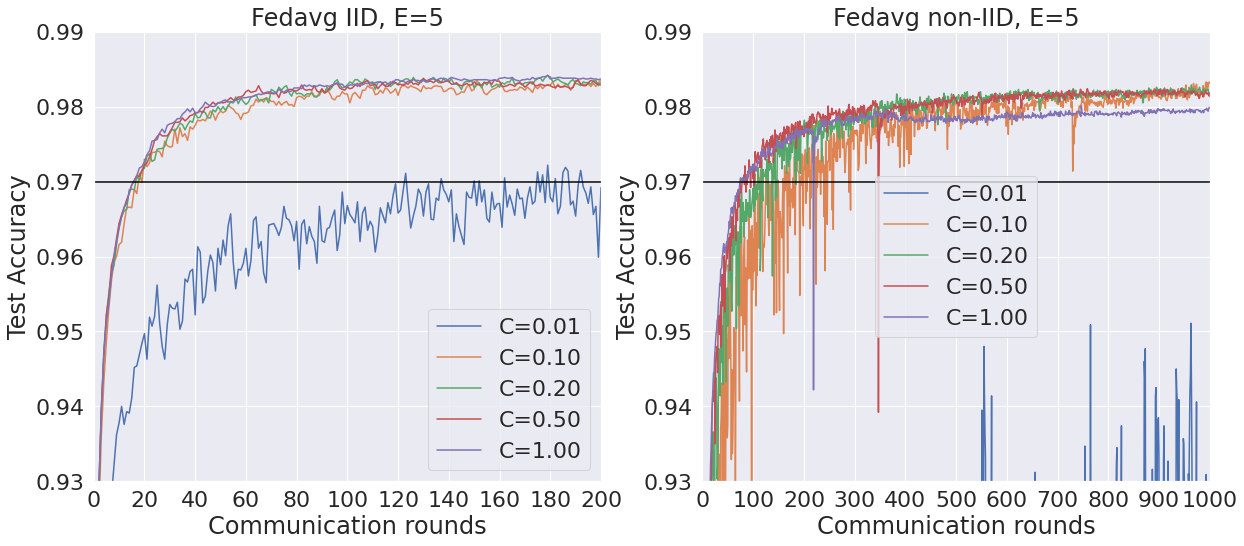

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import matplotlib.ticker as ticker
sns.set_theme(style="darkgrid")
sns.set(rc={'figure.figsize':(20,8.27)})
sns.set(font_scale=2)

C_all= [1, 10, 20, 50, 100]

dfs = []
for C in C_all:
    nr_clients = 100 ### NUMBER OF CLIENTS/ENTITIES
    client_epochs = 5   # Number of client epochs
    communication_rounds = 200  # Number of maximum communication rounds
    test_every_x_round = 1

    dir_str = '{}_{}_{}_{}_{}/'.format(nr_clients, C, client_epochs, communication_rounds, test_every_x_round)
    path = './Results/Fedavg_iid/' + dir_str

    with open(path + 'metrics', 'rb') as metrics_file:
        metrics = pickle.load(metrics_file)

    df = pd.DataFrame.from_dict(metrics[0])
    df.drop(columns=["classification_report"])
    # make_monotonic('accuracy', df)
    df["comm_round"] = [i+1 for i in range(communication_rounds)]
    df['sent_models_per_client'] = [i+1 for i in range(communication_rounds)]
    df['network_load'] = [(i+1)*(C*2) for i in range(communication_rounds)]
    dfs.append(df.assign(Clients="C={}".format(C/100)))

concatenated = pd.concat(dfs)
fig, ax = plt.subplots(1,2)
graph = sns.lineplot(x="comm_round", y="accuracy", hue="Clients", data=concatenated, ax=ax[0])
graph.axhline(0.97, color='black')
handles, labels = graph.get_legend_handles_labels()
labels = add_trailing_zeros(labels)
graph.legend(handles=handles[:], labels=labels[:])
ax[0].set_xlim(0, 200)
ax[0].set_ylim(0.93, 0.99)
graph.xaxis.set_major_locator(ticker.MultipleLocator(20))
graph.set_title('Fedavg IID, E=5')
graph.set_xlabel('Communication rounds')
graph.set_ylabel('Test Accuracy')


dfs = []
for C in C_all:
    nr_clients = 100 ### NUMBER OF CLIENTS/ENTITIES
    client_epochs = 10   # Number of client epochs
    communication_rounds = 1000  # Number of maximum communication rounds
    test_every_x_round = 1

    dir_str = '{}_{}_{}_{}_{}/'.format(nr_clients, C, client_epochs, communication_rounds, test_every_x_round)
    path = './Results/Fedavg_non_iid/' + dir_str

    with open(path + 'metrics', 'rb') as metrics_file:
        metrics = pickle.load(metrics_file)

    df = pd.DataFrame.from_dict(metrics[0])
    df.drop(columns=["classification_report"])
    # make_monotonic('accuracy', df)
    df["comm_round"] = [i+1 for i in range(communication_rounds)]
    df['sent_models_per_client'] = [i+1 for i in range(communication_rounds)]
    df['network_load'] = [(i+1)*(C*2) for i in range(communication_rounds)]
    dfs.append(df.assign(Clients="C={}".format(C/100)))

concatenated = pd.concat(dfs)
graph = sns.lineplot(x="comm_round", y="accuracy", hue="Clients", data=concatenated, ax=ax[1])
graph.axhline(0.97, color='black')
plt.xlim(0, 1000)
plt.ylim(0.93, 0.99)
graph.xaxis.set_major_locator(ticker.MultipleLocator(100))
graph.set_title('Fedavg non-IID, E=5')
graph.set_xlabel('Communication rounds')
graph.set_ylabel('Test Accuracy')

# Remove legend
handles, labels = graph.get_legend_handles_labels()
labels = add_trailing_zeros(labels)
graph.legend(handles=handles[:], labels=labels[:])
#graph.xaxis.set_major_formatter(ticker.ScalarFormatter())
fig.savefig("FedavgCE5.png")

# Fedavg E=10

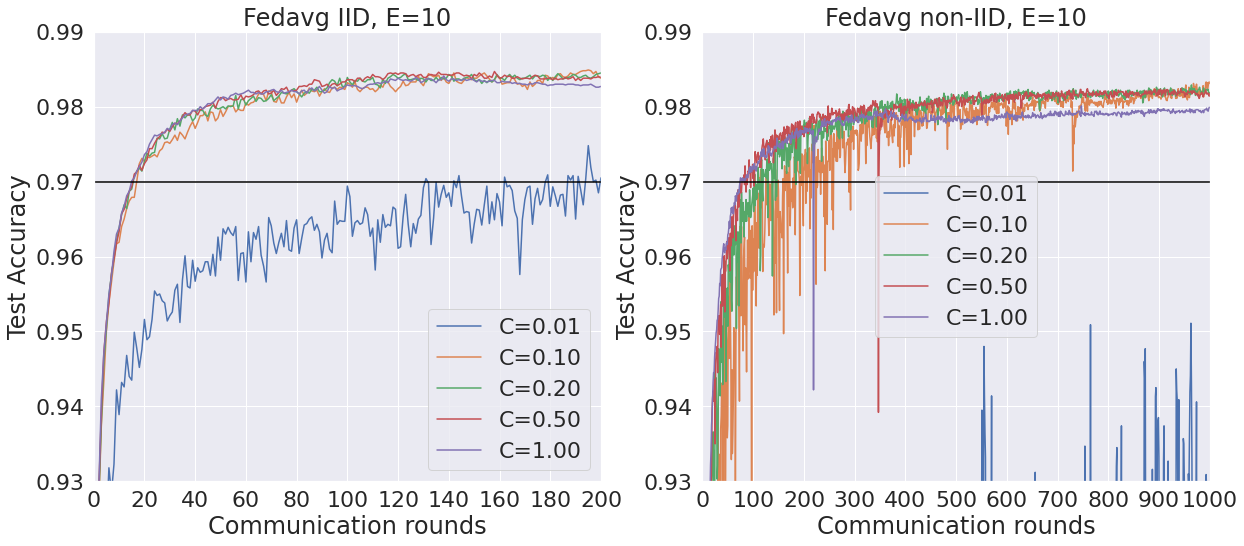

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import matplotlib.ticker as ticker
sns.set_theme(style="darkgrid")
sns.set(rc={'figure.figsize':(20,8.27)})
sns.set(font_scale=2)

C_all= [1, 10, 20, 50, 100]

dfs = []
for C in C_all:
    nr_clients = 100 ### NUMBER OF CLIENTS/ENTITIES
    client_epochs = 10   # Number of client epochs
    communication_rounds = 200  # Number of maximum communication rounds
    test_every_x_round = 1

    dir_str = '{}_{}_{}_{}_{}/'.format(nr_clients, C, client_epochs, communication_rounds, test_every_x_round)
    path = './Results/Fedavg_iid/' + dir_str

    with open(path + 'metrics', 'rb') as metrics_file:
        metrics = pickle.load(metrics_file)

    df = pd.DataFrame.from_dict(metrics[0])
    df.drop(columns=["classification_report"])
    # make_monotonic('accuracy', df)
    df["comm_round"] = [i+1 for i in range(communication_rounds)]
    df['sent_models_per_client'] = [i+1 for i in range(communication_rounds)]
    df['network_load'] = [(i+1)*(C*2) for i in range(communication_rounds)]
    dfs.append(df.assign(Clients="C={}".format(C/100)))

concatenated = pd.concat(dfs)
fig, ax = plt.subplots(1,2)
graph = sns.lineplot(x="comm_round", y="accuracy", hue="Clients", data=concatenated, ax=ax[0])
graph.axhline(0.97, color='black')
handles, labels = graph.get_legend_handles_labels()
labels = add_trailing_zeros(labels)
graph.legend(handles=handles[:], labels=labels[:])
ax[0].set_xlim(0, 200)
ax[0].set_ylim(0.93, 0.99)
graph.xaxis.set_major_locator(ticker.MultipleLocator(20))
graph.set_title('Fedavg IID, E=10')
graph.set_xlabel('Communication rounds')
graph.set_ylabel('Test Accuracy')


dfs = []
for C in C_all:
    nr_clients = 100 ### NUMBER OF CLIENTS/ENTITIES
    client_epochs = 10   # Number of client epochs
    communication_rounds = 1000  # Number of maximum communication rounds
    test_every_x_round = 1

    dir_str = '{}_{}_{}_{}_{}/'.format(nr_clients, C, client_epochs, communication_rounds, test_every_x_round)
    path = './Results/Fedavg_non_iid/' + dir_str

    with open(path + 'metrics', 'rb') as metrics_file:
        metrics = pickle.load(metrics_file)

    df = pd.DataFrame.from_dict(metrics[0])
    df.drop(columns=["classification_report"])
    # make_monotonic('accuracy', df)
    df["comm_round"] = [i+1 for i in range(communication_rounds)]
    df['sent_models_per_client'] = [i+1 for i in range(communication_rounds)]
    df['network_load'] = [(i+1)*(C*2) for i in range(communication_rounds)]
    dfs.append(df.assign(Clients="C={}".format(C/100)))

concatenated = pd.concat(dfs)
graph = sns.lineplot(x="comm_round", y="accuracy", hue="Clients", data=concatenated, ax=ax[1])
graph.axhline(0.97, color='black')
plt.xlim(0, 1000)
plt.ylim(0.93, 0.99)
graph.xaxis.set_major_locator(ticker.MultipleLocator(100))
graph.set_title('Fedavg non-IID, E=10')
graph.set_xlabel('Communication rounds')
graph.set_ylabel('Test Accuracy')

# Remove legend
handles, labels = graph.get_legend_handles_labels()
labels = add_trailing_zeros(labels)
graph.legend(handles=handles[:], labels=labels[:])
#graph.xaxis.set_major_formatter(ticker.ScalarFormatter())
fig.savefig("FedavgCE10.png")

# Fedavg E=20

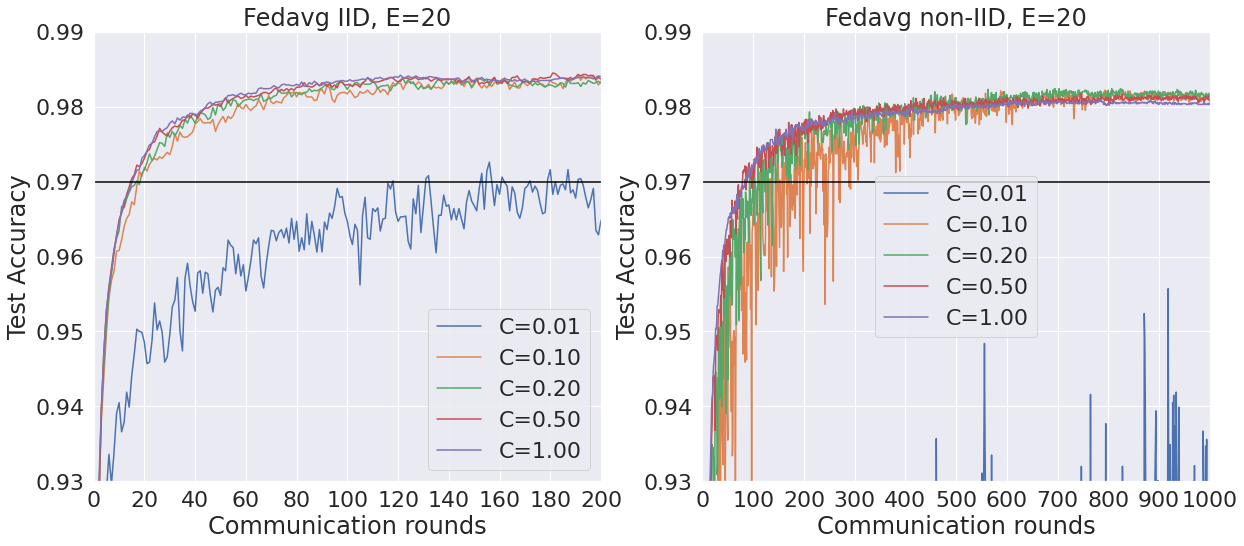

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import matplotlib.ticker as ticker
sns.set_theme(style="darkgrid")
sns.set(rc={'figure.figsize':(20,8.27)})
sns.set(font_scale=2)

C_all= [1, 10, 20, 50, 100]

dfs = []
for C in C_all:
    nr_clients = 100 ### NUMBER OF CLIENTS/ENTITIES
    client_epochs = 20   # Number of client epochs
    communication_rounds = 200  # Number of maximum communication rounds
    test_every_x_round = 1

    dir_str = '{}_{}_{}_{}_{}/'.format(nr_clients, C, client_epochs, communication_rounds, test_every_x_round)
    path = './Results/Fedavg_iid/' + dir_str

    with open(path + 'metrics', 'rb') as metrics_file:
        metrics = pickle.load(metrics_file)

    df = pd.DataFrame.from_dict(metrics[0])
    df.drop(columns=["classification_report"])
    # make_monotonic('accuracy', df)
    df["comm_round"] = [i+1 for i in range(communication_rounds)]
    df['sent_models_per_client'] = [i+1 for i in range(communication_rounds)]
    df['network_load'] = [(i+1)*(C*2) for i in range(communication_rounds)]
    dfs.append(df.assign(Clients="C={}".format(C/100)))

concatenated = pd.concat(dfs)
fig, ax = plt.subplots(1,2)
graph = sns.lineplot(x="comm_round", y="accuracy", hue="Clients", data=concatenated, ax=ax[0])
graph.axhline(0.97, color='black')
handles, labels = graph.get_legend_handles_labels()
labels = add_trailing_zeros(labels)
graph.legend(handles=handles[:], labels=labels[:])
ax[0].set_xlim(0, 200)
ax[0].set_ylim(0.93, 0.99)
graph.xaxis.set_major_locator(ticker.MultipleLocator(20))
graph.set_title('Fedavg IID, E=20')
graph.set_xlabel('Communication rounds')
graph.set_ylabel('Test Accuracy')


dfs = []
for C in C_all:
    nr_clients = 100 ### NUMBER OF CLIENTS/ENTITIES
    client_epochs = 20   # Number of client epochs
    communication_rounds = 1000  # Number of maximum communication rounds
    test_every_x_round = 1

    dir_str = '{}_{}_{}_{}_{}/'.format(nr_clients, C, client_epochs, communication_rounds, test_every_x_round)
    path = './Results/Fedavg_non_iid/' + dir_str

    with open(path + 'metrics', 'rb') as metrics_file:
        metrics = pickle.load(metrics_file)

    df = pd.DataFrame.from_dict(metrics[0])
    df.drop(columns=["classification_report"])
    # make_monotonic('accuracy', df)
    df["comm_round"] = [i+1 for i in range(communication_rounds)]
    df['sent_models_per_client'] = [i+1 for i in range(communication_rounds)]
    df['network_load'] = [(i+1)*(C*2) for i in range(communication_rounds)]
    dfs.append(df.assign(Clients="C={}".format(C/100)))

concatenated = pd.concat(dfs)
graph = sns.lineplot(x="comm_round", y="accuracy", hue="Clients", data=concatenated, ax=ax[1])
graph.axhline(0.97, color='black')
plt.xlim(0, 1000)
plt.ylim(0.93, 0.99)
graph.xaxis.set_major_locator(ticker.MultipleLocator(100))
graph.set_title('Fedavg non-IID, E=20')
graph.set_xlabel('Communication rounds')
graph.set_ylabel('Test Accuracy')

# Remove legend
handles, labels = graph.get_legend_handles_labels()
labels = add_trailing_zeros(labels)
graph.legend(handles=handles[:], labels=labels[:])
#graph.xaxis.set_major_formatter(ticker.ScalarFormatter())
fig.savefig("FedavgCE20.png")

# 97% accuracy plots

{'C': [0.01, 0.1, 0.2, 0.5, 1.0], 'sent_models_per_client': [1.71, 3.5, 6.0, 13.5, 29.0], 'network_load': [271.0, 450.0, 700.0, 1450.0, 3000.0], 'comm_round': [171, 35, 30, 27, 29]}
{'C': [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1], 'sent_models_per_client': [60, 80, 150, 200, 400, 1000, 1980], 'network_load': [6000, 8000, 15000, 20000, 40000, 100000, 198000], 'comm_round': [60, 40, 30, 20, 20, 20, 20]}
{'C': [0.1, 0.2, 0.5, 1.0], 'sent_models_per_client': [11.3, 18.6, 40.0, 84.0], 'network_load': [1230.0, 1960.0, 4100.0, 8500.0], 'comm_round': [113, 93, 80, 84]}
{'C': [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1], 'sent_models_per_client': [670, 960, 1150, 1600, 2400, 4500, 8910], 'network_load': [67000, 96000, 115000, 160000, 240000, 450000, 891000], 'comm_round': [670, 480, 230, 160, 120, 90, 90]}
{'C': [0.02, 0.05, 0.2, 0.5], 'sent_models_per_client': [960, 1150, 2200, 4500], 'network_load': [96000, 115000, 220000, 450000], 'comm_round': [480, 230, 110, 90]}
{'C': [0.02, 0.05, 0.2, 0.5], 'sent_mod

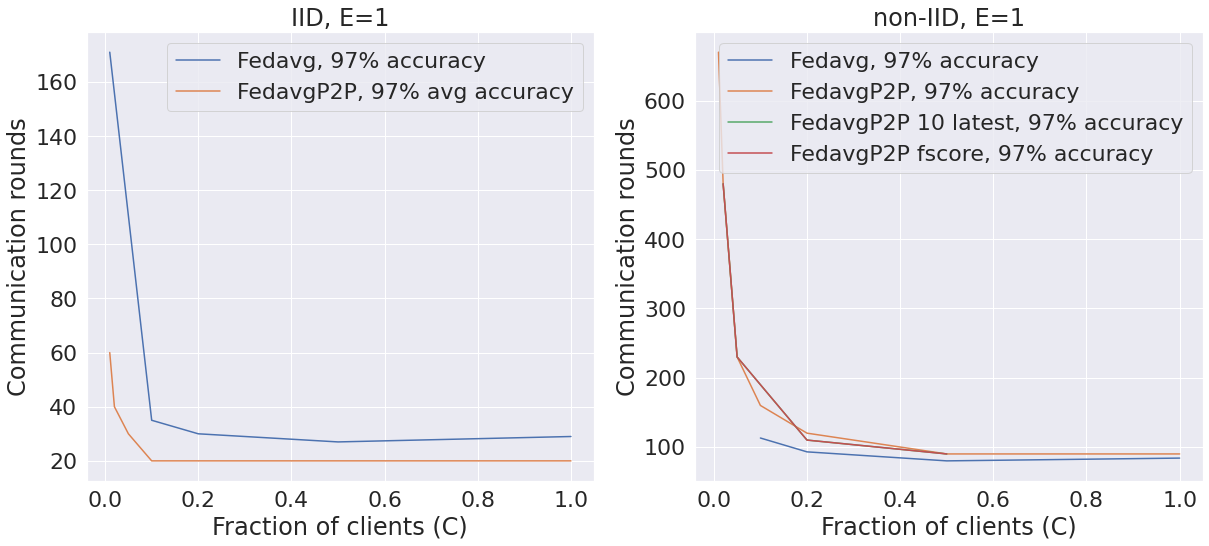

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import math
#sns.set_theme(style="darkgrid")
sns.set_theme(style="darkgrid")
sns.set(rc={'figure.figsize':(20,8.27)})
sns.set(font_scale=2)
dfs = []

reach_threshhold = get_metrics_fedavg(1, 200, True)
print(reach_threshhold)
fig, ax = plt.subplots(1,2)
df = pd.DataFrame(reach_threshhold)
df = df.assign(Alg="Fedavg, 97% accuracy")
dfs.append(df)


reach_threshhold = get_metrics_p2p(5, 200, True)
print(reach_threshhold)
df = pd.DataFrame(reach_threshhold)
df = df.assign(Alg="FedavgP2P, 97% avg accuracy")
dfs.append(df)
concatenated = pd.concat(dfs)
graph = sns.lineplot(x="C", y="comm_round", hue="Alg", data=concatenated, ax=ax[0])
# Remove legend
handles, labels = graph.get_legend_handles_labels()
graph.legend(handles=handles[:], labels=labels[:])
graph.set_title("IID, E=1")
graph.set_ylabel('Communication rounds')
graph.set_xlabel('Fraction of clients (C)')

dfs = []

reach_threshhold = get_metrics_fedavg(5, 1000, False)
print(reach_threshhold)
df = pd.DataFrame(reach_threshhold)
df = df.assign(Alg="Fedavg, 97% accuracy")
dfs.append(df)


reach_threshhold = get_metrics_p2p(5, 1000, False)
print(reach_threshhold)
df = pd.DataFrame(reach_threshhold)
df = df.assign(Alg="FedavgP2P, 97% accuracy")
dfs.append(df)
concatenated = pd.concat(dfs)

reach_threshhold = get_metrics_p2p_heur(5, 1000, False)
print(reach_threshhold)
df = pd.DataFrame(reach_threshhold)
df = df.assign(Alg="FedavgP2P 10 latest, 97% accuracy")
dfs.append(df)
concatenated = pd.concat(dfs)

reach_threshhold = get_metrics_p2p_heur(5, 1000, False)
print(reach_threshhold)
df = pd.DataFrame(reach_threshhold)
df = df.assign(Alg="FedavgP2P fscore, 97% accuracy")
dfs.append(df)
concatenated = pd.concat(dfs)

graph = sns.lineplot(x="C", y="comm_round", hue="Alg", data=concatenated, ax=ax[1])# Remove legend
handles, labels = graph.get_legend_handles_labels()
graph.legend(handles=handles[:], labels=labels[:])
graph.set_title("non-IID, E=1")
graph.set_ylabel('Communication rounds')
graph.set_xlabel('Fraction of clients (C)')

fig.savefig("CommroundsC.png")

# Heur plots

{'C': [0.02, 0.05, 0.2, 0.5], 'sent_models_per_client': [960, 1150, 2200, 4500], 'network_load': [96000, 115000, 220000, 450000], 'comm_round': [480, 230, 110, 90]}
{'C': [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1], 'sent_models_per_client': [670, 960, 1150, 1600, 2400, 4500, 8910], 'network_load': [67000, 96000, 115000, 160000, 240000, 450000, 891000], 'comm_round': [670, 480, 230, 160, 120, 90, 90]}


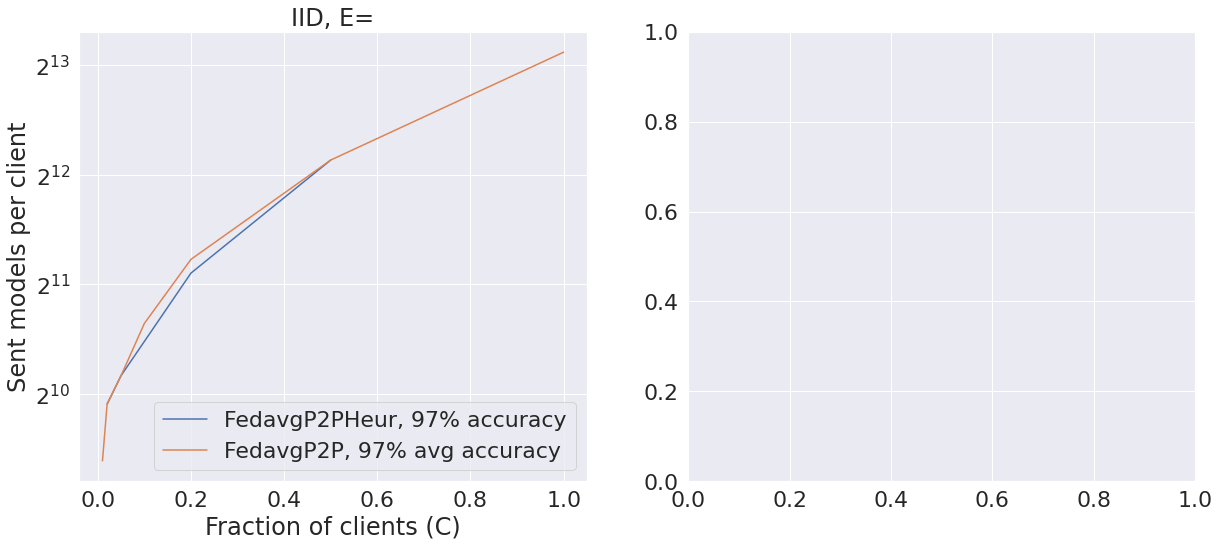

In [75]:
dfs = []

reach_threshhold = get_metrics_p2p_heur(5, 1000, False)
print(reach_threshhold)
fig, ax = plt.subplots(1,2)
df = pd.DataFrame(reach_threshhold)
df = df.assign(Alg="FedavgP2PHeur, 97% accuracy")
dfs.append(df)


reach_threshhold = get_metrics_p2p(5, 1000, False)
print(reach_threshhold)
df = pd.DataFrame(reach_threshhold)
df = df.assign(Alg="FedavgP2P, 97% avg accuracy")
dfs.append(df)
concatenated = pd.concat(dfs)
graph = sns.lineplot(x="C", y="sent_models_per_client", hue="Alg", data=concatenated, ax=ax[0])
ax[0].set_yscale('log', base=2)

# Remove legend
handles, labels = graph.get_legend_handles_labels()
graph.legend(handles=handles[:], labels=labels[:])
graph.set_title("IID, E=")
graph.set_ylabel('Sent models per client')
graph.set_xlabel('Fraction of clients (C)')

dfs = []

# reach_threshhold = get_metrics_p2p_heur(5, 1000, False)
# print(reach_threshhold)
# df = pd.DataFrame(reach_threshhold)
# df = df.assign(Alg="FedavgP2Pheur, 97% accuracy")
# dfs.append(df)


# reach_threshhold = get_metrics_p2p(5, 1000, False)
# print(reach_threshhold)
# df = pd.DataFrame(reach_threshhold)
# df = df.assign(Alg="FedavgP2P, 97% avg accuracy")
# dfs.append(df)
# concatenated = pd.concat(dfs)
# graph = sns.lineplot(x="C", y="sent_models_per_client", hue="Alg", data=concatenated, ax=ax[1])
# ax[1].set_yscale('log', base=2)
# # Remove legend
# handles, labels = graph.get_legend_handles_labels()
# graph.legend(handles=handles[:], labels=labels[:])
# graph.set_title("non-IID, E=5")
# graph.set_ylabel('Sent models per client')
# graph.set_xlabel('Fraction of clients (C)')

fig.savefig("ModelsPerClientC.png")

{'C': [0.01, 0.1, 0.2, 0.5, 1.0], 'sent_models_per_client': [1.23, 1.8, 3.4, 8.0, 16.0], 'network_load': [223.0, 280.0, 440.0, 900.0, 1700.0], 'comm_round': [123, 18, 17, 16, 16]}
{'C': [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1], 'sent_models_per_client': [60, 80, 150, 200, 400, 1000, 1980], 'network_load': [6000, 8000, 15000, 20000, 40000, 100000, 198000], 'comm_round': [60, 40, 30, 20, 20, 20, 20]}
{'C': [0.1, 0.2, 0.5, 1.0], 'sent_models_per_client': [11.3, 18.6, 40.0, 84.0], 'network_load': [1230.0, 1960.0, 4100.0, 8500.0], 'comm_round': [113, 93, 80, 84]}
{'C': [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1], 'sent_models_per_client': [670, 960, 1150, 1600, 2400, 4500, 8910], 'network_load': [67000, 96000, 115000, 160000, 240000, 450000, 891000], 'comm_round': [670, 480, 230, 160, 120, 90, 90]}
{'C': [0.02, 0.05, 0.2, 0.5], 'sent_models_per_client': [960, 1150, 2200, 4500], 'network_load': [96000, 115000, 220000, 450000], 'comm_round': [480, 230, 110, 90]}
{'C': [0.02, 0.05, 0.1, 0.2, 0.5, 1], 'se

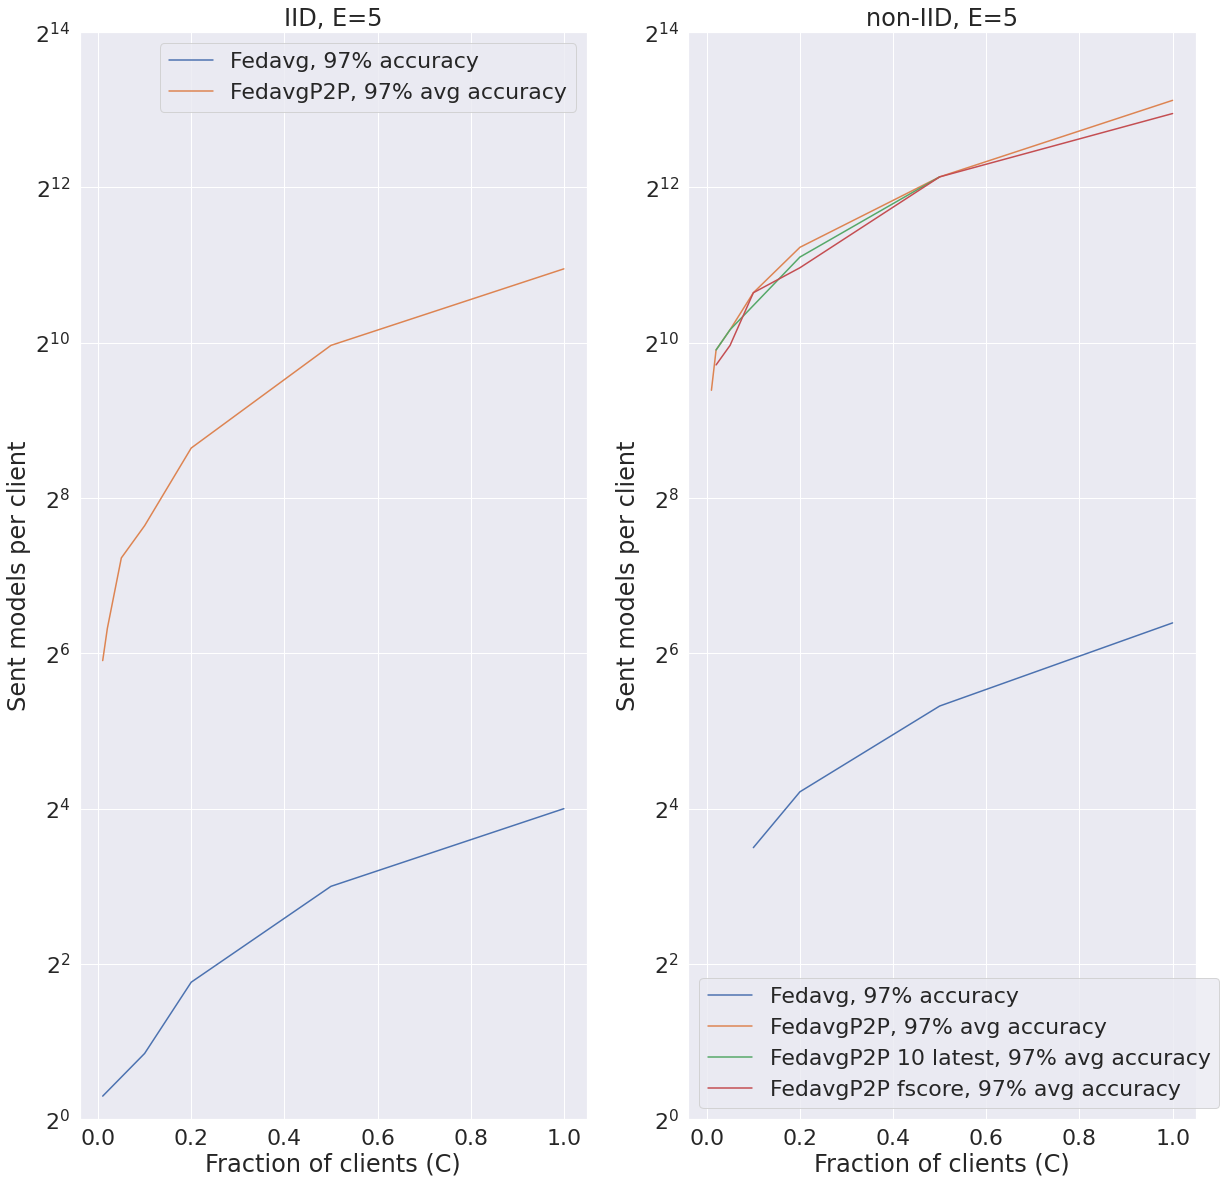

In [3]:
dfs = []

reach_threshhold = get_metrics_fedavg(5, 200, True)
print(reach_threshhold)
fig, ax = plt.subplots(1,2)
df = pd.DataFrame(reach_threshhold)
df = df.assign(Alg="Fedavg, 97% accuracy")
dfs.append(df)


reach_threshhold = get_metrics_p2p(5, 200, True)
print(reach_threshhold)
df = pd.DataFrame(reach_threshhold)
df = df.assign(Alg="FedavgP2P, 97% avg accuracy")
dfs.append(df)
concatenated = pd.concat(dfs)
graph = sns.lineplot(x="C", y="sent_models_per_client", hue="Alg", data=concatenated, ax=ax[0])
ax[0].set_yscale('log', base=2)
ax[0].set_ylim(2**0, 2**14)

# Remove legend
handles, labels = graph.get_legend_handles_labels()
graph.legend(handles=handles[:], labels=labels[:])
graph.set_title("IID, E=5")
graph.set_ylabel('Sent models per client')
graph.set_xlabel('Fraction of clients (C)')

dfs = []

reach_threshhold = get_metrics_fedavg(5, 1000, False)
print(reach_threshhold)
df = pd.DataFrame(reach_threshhold)
df = df.assign(Alg="Fedavg, 97% accuracy")
dfs.append(df)


reach_threshhold = get_metrics_p2p(5, 1000, False)
print(reach_threshhold)
df = pd.DataFrame(reach_threshhold)
df = df.assign(Alg="FedavgP2P, 97% avg accuracy")
dfs.append(df)
concatenated = pd.concat(dfs)

reach_threshhold = get_metrics_p2p_heur(5, 1000, False)
print(reach_threshhold)
df = pd.DataFrame(reach_threshhold)
df = df.assign(Alg="FedavgP2P 10 latest, 97% avg accuracy")
dfs.append(df)
concatenated = pd.concat(dfs)

reach_threshhold = get_metrics_p2p_acc(5, 1000, False)
print(reach_threshhold)
df = pd.DataFrame(reach_threshhold)
df = df.assign(Alg="FedavgP2P fscore, 97% avg accuracy")
dfs.append(df)
concatenated = pd.concat(dfs)
graph = sns.lineplot(x="C", y="sent_models_per_client", hue="Alg", data=concatenated, ax=ax[1])


ax[1].set_yscale('log', base=2)
ax[1].set_ylim(2**0, 2**14)
# Remove legend
handles, labels = graph.get_legend_handles_labels()
graph.legend(handles=handles[:], labels=labels[:])
graph.set_title("non-IID, E=5")
graph.set_ylabel('Sent models per client')
graph.set_xlabel('Fraction of clients (C)')

fig.savefig("ModelsPerClientC.png")

{'C': [0.01, 0.1, 0.2, 0.5, 1.0], 'sent_models_per_client': [1.71, 3.5, 6.0, 13.5, 29.0], 'network_load': [271.0, 450.0, 700.0, 1450.0, 3000.0], 'comm_round': [171, 35, 30, 27, 29]}
{'C': [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1], 'sent_models_per_client': [80, 120, 200, 400, 800, 1500, 2970], 'network_load': [8000, 12000, 20000, 40000, 80000, 150000, 297000], 'comm_round': [80, 60, 40, 40, 40, 30, 30]}
{'C': [0.01, 0.1, 0.2, 0.5, 1.0], 'sent_models_per_client': [1.71, 3.5, 6.0, 13.5, 29.0], 'network_load': [271.0, 450.0, 700.0, 1450.0, 3000.0], 'comm_round': [171, 35, 30, 27, 29]}
{'C': [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1], 'sent_models_per_client': [60, 80, 150, 200, 400, 1000, 1980], 'network_load': [6000, 8000, 15000, 20000, 40000, 100000, 198000], 'comm_round': [60, 40, 30, 20, 20, 20, 20]}
{'C': [0.01, 0.1, 0.2, 0.5, 1.0], 'sent_models_per_client': [1.31, 1.7, 3.2, 8.0, 15.0], 'network_load': [231.0, 270.0, 420.0, 900.0, 1600.0], 'comm_round': [131, 17, 16, 16, 15]}
{'C': [0.01, 0.02,

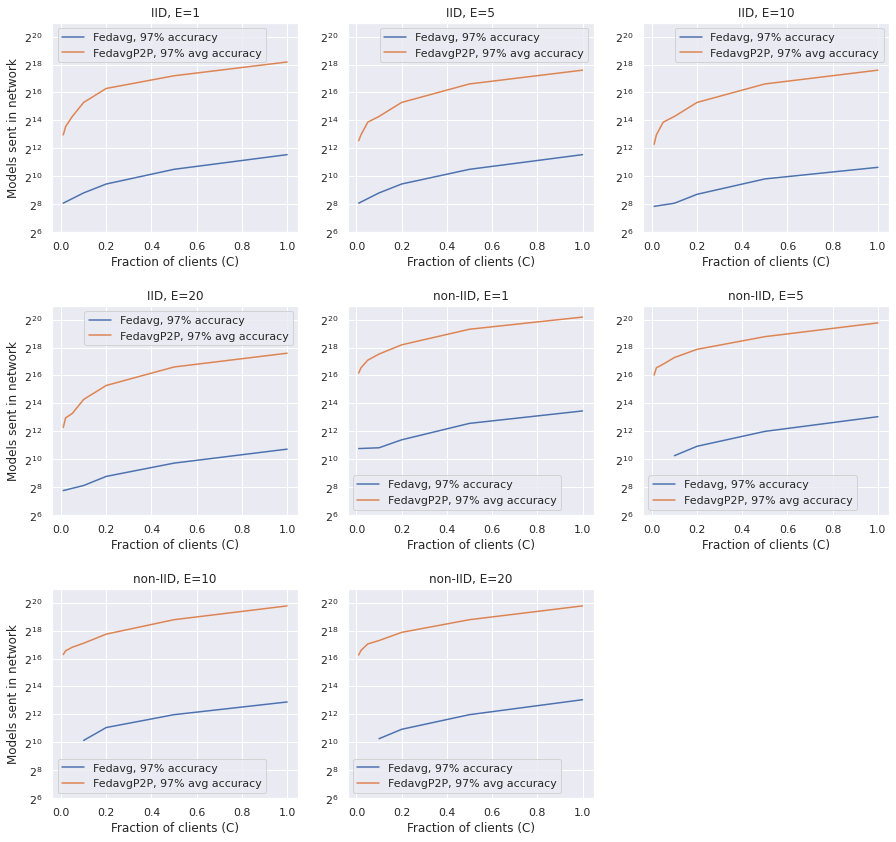

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import matplotlib.ticker as ticker
sns.set_theme(style="darkgrid")
sns.set(rc={'figure.figsize':(15,14.27)})
sns.set(font_scale=1)
fig, ax = plt.subplots(3,3)
fig.subplots_adjust(hspace=0.35)
dfs = []

reach_threshhold = get_metrics_fedavg(1, 200, True)
print(reach_threshhold)

df = pd.DataFrame(reach_threshhold)
df = df.assign(Alg="Fedavg, 97% accuracy")
dfs.append(df)


reach_threshhold = get_metrics_p2p(1, 200, True)
print(reach_threshhold)
df = pd.DataFrame(reach_threshhold)
df = df.assign(Alg="FedavgP2P, 97% avg accuracy")
dfs.append(df)
concatenated = pd.concat(dfs)
graph = sns.lineplot(x="C", y="network_load", hue="Alg", data=concatenated, ax=ax[0][0])
ax[0][0].set_yscale('log', base=2)
ax[0][0].set_ylim(2**6, 2**21)

# Remove legend
handles, labels = graph.get_legend_handles_labels()
graph.legend(handles=handles[:], labels=labels[:])
graph.set_title("IID, E=1")
graph.set_ylabel('Models sent in network')
graph.set_xlabel('Fraction of clients (C)')

#####################################################################

dfs = []

reach_threshhold = get_metrics_fedavg(1, 200, True)
print(reach_threshhold)

df = pd.DataFrame(reach_threshhold)
df = df.assign(Alg="Fedavg, 97% accuracy")
dfs.append(df)


reach_threshhold = get_metrics_p2p(5, 200, True)
print(reach_threshhold)
df = pd.DataFrame(reach_threshhold)
df = df.assign(Alg="FedavgP2P, 97% avg accuracy")
dfs.append(df)
concatenated = pd.concat(dfs)
graph = sns.lineplot(x="C", y="network_load", hue="Alg", data=concatenated, ax=ax[0][1])
ax[0][1].set_yscale('log', base=2)
ax[0][1].set_ylim(2**6, 2**21)

# Remove legend
handles, labels = graph.get_legend_handles_labels()
graph.legend(handles=handles[:], labels=labels[:])
graph.set_title("IID, E=5")
graph.set_ylabel('')
graph.set_xlabel('Fraction of clients (C)')

######################################################################

#####################################################################

dfs = []

reach_threshhold = get_metrics_fedavg(10, 200, True)
print(reach_threshhold)

df = pd.DataFrame(reach_threshhold)
df = df.assign(Alg="Fedavg, 97% accuracy")
dfs.append(df)


reach_threshhold = get_metrics_p2p(10, 200, True)
print(reach_threshhold)
df = pd.DataFrame(reach_threshhold)
df = df.assign(Alg="FedavgP2P, 97% avg accuracy")
dfs.append(df)
concatenated = pd.concat(dfs)
graph = sns.lineplot(x="C", y="network_load", hue="Alg", data=concatenated, ax=ax[0][2])
ax[0][2].set_yscale('log', base=2)
ax[0][2].set_ylim(2**6, 2**21)

# Remove legend
handles, labels = graph.get_legend_handles_labels()
graph.legend(handles=handles[:], labels=labels[:])
graph.set_title("IID, E=10")
graph.set_ylabel('')
graph.set_xlabel('Fraction of clients (C)')

######################################################################

#####################################################################

dfs = []

reach_threshhold = get_metrics_fedavg(20, 200, True)
print(reach_threshhold)

df = pd.DataFrame(reach_threshhold)
df = df.assign(Alg="Fedavg, 97% accuracy")
dfs.append(df)


reach_threshhold = get_metrics_p2p(20, 200, True)
print(reach_threshhold)
df = pd.DataFrame(reach_threshhold)
df = df.assign(Alg="FedavgP2P, 97% avg accuracy")
dfs.append(df)
concatenated = pd.concat(dfs)
graph = sns.lineplot(x="C", y="network_load", hue="Alg", data=concatenated, ax=ax[1][0])
ax[1][0].set_yscale('log', base=2)
ax[1][0].set_ylim(2**6, 2**21)

# Remove legend
handles, labels = graph.get_legend_handles_labels()
graph.legend(handles=handles[:], labels=labels[:])
graph.set_title("IID, E=20")
graph.set_ylabel('Models sent in network')
graph.set_xlabel('Fraction of clients (C)')

######################################################################



dfs = []

reach_threshhold = get_metrics_fedavg(5, 1000, False)
print(reach_threshhold)
df = pd.DataFrame(reach_threshhold)
df = df.assign(Alg="Fedavg, 97% accuracy")
dfs.append(df)


reach_threshhold = get_metrics_p2p(5, 1000, False)
print(reach_threshhold)
df = pd.DataFrame(reach_threshhold)
df = df.assign(Alg="FedavgP2P, 97% avg accuracy")
dfs.append(df)
concatenated = pd.concat(dfs)

graph = sns.lineplot(x="C", y="network_load", hue="Alg", data=concatenated, ax=ax[1][2])


ax[1][2].set_yscale('log', base=2)
ax[1][2].set_ylim(2**6, 2**21)
# Remove legend
handles, labels = graph.get_legend_handles_labels()
graph.legend(handles=handles[:], labels=labels[:])
graph.set_title("non-IID, E=5")
graph.set_ylabel('')
graph.set_xlabel('Fraction of clients (C)')

######################################################################



dfs = []

reach_threshhold = get_metrics_fedavg(1, 1000, False)
print(reach_threshhold)
df = pd.DataFrame(reach_threshhold)
df = df.assign(Alg="Fedavg, 97% accuracy")
dfs.append(df)


reach_threshhold = get_metrics_p2p(1, 1000, False)
print(reach_threshhold)
df = pd.DataFrame(reach_threshhold)
df = df.assign(Alg="FedavgP2P, 97% avg accuracy")
dfs.append(df)
concatenated = pd.concat(dfs)

graph = sns.lineplot(x="C", y="network_load", hue="Alg", data=concatenated, ax=ax[1][1])


ax[1][1].set_yscale('log', base=2)
ax[1][1].set_ylim(2**6, 2**21)
# Remove legend
handles, labels = graph.get_legend_handles_labels()
graph.legend(handles=handles[:], labels=labels[:])
graph.set_title("non-IID, E=1")
graph.set_ylabel('')
graph.set_xlabel('Fraction of clients (C)')

######################################################################



dfs = []

reach_threshhold = get_metrics_fedavg(10, 1000, False)
print(reach_threshhold)
df = pd.DataFrame(reach_threshhold)
df = df.assign(Alg="Fedavg, 97% accuracy")
dfs.append(df)


reach_threshhold = get_metrics_p2p(10, 1000, False)
print(reach_threshhold)
df = pd.DataFrame(reach_threshhold)
df = df.assign(Alg="FedavgP2P, 97% avg accuracy")
dfs.append(df)
concatenated = pd.concat(dfs)

graph = sns.lineplot(x="C", y="network_load", hue="Alg", data=concatenated, ax=ax[2][0])


ax[2][0].set_yscale('log', base=2)
ax[2][0].set_ylim(2**6, 2**21)
# Remove legend
handles, labels = graph.get_legend_handles_labels()
graph.legend(handles=handles[:], labels=labels[:])
graph.set_title("non-IID, E=10")
graph.set_ylabel('Models sent in network')
graph.set_xlabel('Fraction of clients (C)')

######################################################################



dfs = []

reach_threshhold = get_metrics_fedavg(20, 1000, False)
print(reach_threshhold)
df = pd.DataFrame(reach_threshhold)
df = df.assign(Alg="Fedavg, 97% accuracy")
dfs.append(df)


reach_threshhold = get_metrics_p2p(20, 1000, False)
print(reach_threshhold)
df = pd.DataFrame(reach_threshhold)
df = df.assign(Alg="FedavgP2P, 97% avg accuracy")
dfs.append(df)
concatenated = pd.concat(dfs)

graph = sns.lineplot(x="C", y="network_load", hue="Alg", data=concatenated, ax=ax[2][1])


ax[2][1].set_yscale('log', base=2)
ax[2][1].set_ylim(2**6, 2**21)
# Remove legend
handles, labels = graph.get_legend_handles_labels()
graph.legend(handles=handles[:], labels=labels[:])
graph.set_title("non-IID, E=20")
graph.set_ylabel('')
graph.set_xlabel('Fraction of clients (C)')

ax[2][2].set_visible(False)

fig.savefig("Totalmodels.png")

In [7]:

metrics = get_metrics_p2p_acc_fix(5, 1000, False)
for j in range(6):
    print(metrics['C'][j])
    print("{} ({:.2f})x, {} ({:.2f}x)".format(int(metrics['comm_round'][j]), 1649/metrics['comm_round'][j],metrics['network_load'][j], 1749/metrics['network_load'][j]))




0.02
450 (3.66)x, 90000 (0.02x)
0.05
170 (9.70)x, 85000 (0.02x)
0.1
140 (11.78)x, 140000 (0.01x)
0.2
110 (14.99)x, 220000 (0.01x)
0.5
100 (16.49)x, 500000 (0.00x)
1
80 (20.61)x, 792000 (0.00x)


In [ ]:
      1 & 0.01 & &  \\
      1 & 0.02 & &  \\
      1 & 0.05 & &  \\
      1 & 0.10 & &  \\
      1 & 0.20 & &  \\
      1 & 0.50 & &  \\
      1 & 1.00 & &  \\
      5 & 0.01 & &  \\
      5 & 0.02 & &  \\
      5 & 0.05 & &  \\
      5 & 0.10 & &  \\
      5 & 0.20 & &  \\
      5 & 0.50 & &  \\
      5 & 1.00 & &  \\
      10 & 0.01 & &  \\
      10 & 0.02 & &  \\
      10 & 0.05 & &  \\
      10 & 0.10 & &  \\
      10 & 0.20 & &  \\
      10 & 0.50 & &  \\
      10 & 1.00 & &  \\
      20 & 0.01 & &  \\
      20 & 0.02 & &  \\
      20 & 0.05 & &  \\
      20 & 0.10 & &  \\
      20 & 0.20 & &  \\
      20 & 0.50 & &  \\
      20 & 1.00 & &  \\

# P2P 1 Epoch

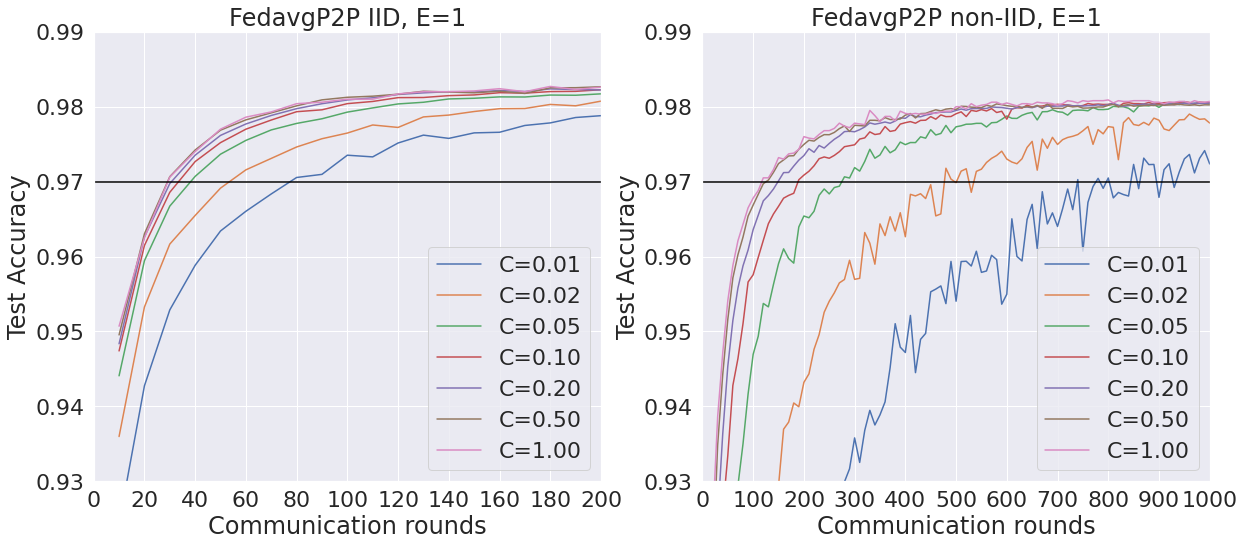

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import matplotlib.ticker as ticker
sns.set_theme(style="darkgrid")
sns.set(rc={'figure.figsize':(20,8.27)})
sns.set(font_scale=2)

C_all=[1, 2, 5, 10, 20, 50, 99]
dfs = []
for C in C_all:
    nr_clients = 100 ### NUMBER OF CLIENTS/ENTITIES
    client_epochs = 1   # Number of client epochs
    communication_rounds = 200  # Number of maximum communication rounds
    test_every_x_round = 10

    dir_str = '{}_{}_{}_{}_{}/'.format(nr_clients, C, client_epochs, communication_rounds, test_every_x_round)
    path = './Results/P2P_iid/' + dir_str

    with open(path + 'metrics', 'rb') as metrics_file:
        metrics_p2p = pickle.load(metrics_file)

    # per node communication
    # C*nr_clients*round

    avgs =  [calc_avg_clients_metrics(metrics_p2p[0][i]) for i in range(communication_rounds//test_every_x_round)]
    df_p2p = pd.DataFrame(avgs)
    # make_monotonic('average_accuracy', df_p2p)
    comm_round = [i for i in range(10,210,10)]
    sent_models_per_client = [C*i for i in range(10, 210, 10)]
    # neighbors * communication_round/epoch

    # 0 indexed
    df_p2p['comm_round'] = comm_round
    df_p2p['sent_models_per_client'] = sent_models_per_client
    df_p2p['network_load'] = [i*nr_clients*C for i in range(10, 210, 10)]
    # change columns to match centralized
    df_p2p.columns = ['accuracy', 'precision', 'recall', 'f1','loss', 'comm_round', 'sent_models_per_client', 'network_load']
    if C == 99:
        dfs.append(df_p2p.assign(Clients="C={}".format(1.0)))
    else:
        dfs.append(df_p2p.assign(Clients="C={}".format(C/100)))

concatenated = pd.concat(dfs)
fig, ax = plt.subplots(1,2)
graph = sns.lineplot(x="comm_round", y="accuracy", hue="Clients", data=concatenated, ax=ax[0])
graph.axhline(0.97, color='black')
handles, labels = graph.get_legend_handles_labels()
labels = add_trailing_zeros(labels)
graph.legend(handles=handles[:], labels=labels[:])
ax[0].set_xlim(0, 200)
ax[0].set_ylim(0.93, 0.99)
graph.xaxis.set_major_locator(ticker.MultipleLocator(20))
graph.set_title('FedavgP2P IID, E=1')
graph.set_xlabel('Communication rounds')
graph.set_ylabel('Test Accuracy')


dfs = []
for C in C_all:
    nr_clients = 100 ### NUMBER OF CLIENTS/ENTITIES
    client_epochs = 1   # Number of client epochs
    communication_rounds = 1000  # Number of maximum communication rounds
    test_every_x_round = 10

    dir_str = '{}_{}_{}_{}_{}/'.format(nr_clients, C, client_epochs, communication_rounds, test_every_x_round)
    path = './Results/P2P_non_iid/' + dir_str

    with open(path + 'metrics', 'rb') as metrics_file:
        metrics_p2p = pickle.load(metrics_file)

    # per node communication
    # C*nr_clients*round

    avgs =  [calc_avg_clients_metrics(metrics_p2p[0][i]) for i in range(communication_rounds//test_every_x_round)]
    df_p2p = pd.DataFrame(avgs)
    # make_monotonic('average_accuracy', df_p2p)
    comm_round = [i for i in range(10,1010,10)]
    sent_models_per_client = [C*i for i in range(10, 1010, 10)]
    # neighbors * communication_round/epoch

    # 0 indexed
    df_p2p['comm_round'] = comm_round
    df_p2p['sent_models_per_client'] = sent_models_per_client
    df_p2p['network_load'] = [i*nr_clients*C for i in range(10, 1010, 10)]
    # change columns to match centralized
    df_p2p.columns = ['accuracy', 'precision', 'recall', 'f1','loss', 'comm_round', 'sent_models_per_client', 'network_load']
    if C == 99:
        dfs.append(df_p2p.assign(Clients="C={}".format(1.0)))
    else:
        dfs.append(df_p2p.assign(Clients="C={}".format(C/100)))

concatenated = pd.concat(dfs)
graph = sns.lineplot(x="comm_round", y="accuracy", hue="Clients", data=concatenated, ax=ax[1])
graph.axhline(0.97, color='black')
labels = add_trailing_zeros(labels)
graph.legend(handles=handles[:], labels=labels[:])

ax[1].set_xlim(0, 1000)
ax[1].set_ylim(0.93, 0.99)
graph.xaxis.set_major_locator(ticker.MultipleLocator(100))
graph.set_title('FedavgP2P non-IID, E=1')
graph.set_xlabel('Communication rounds')
graph.set_ylabel('Test Accuracy')



fig.savefig("FedavgP2PE1.png")

# P2P 5 epochs

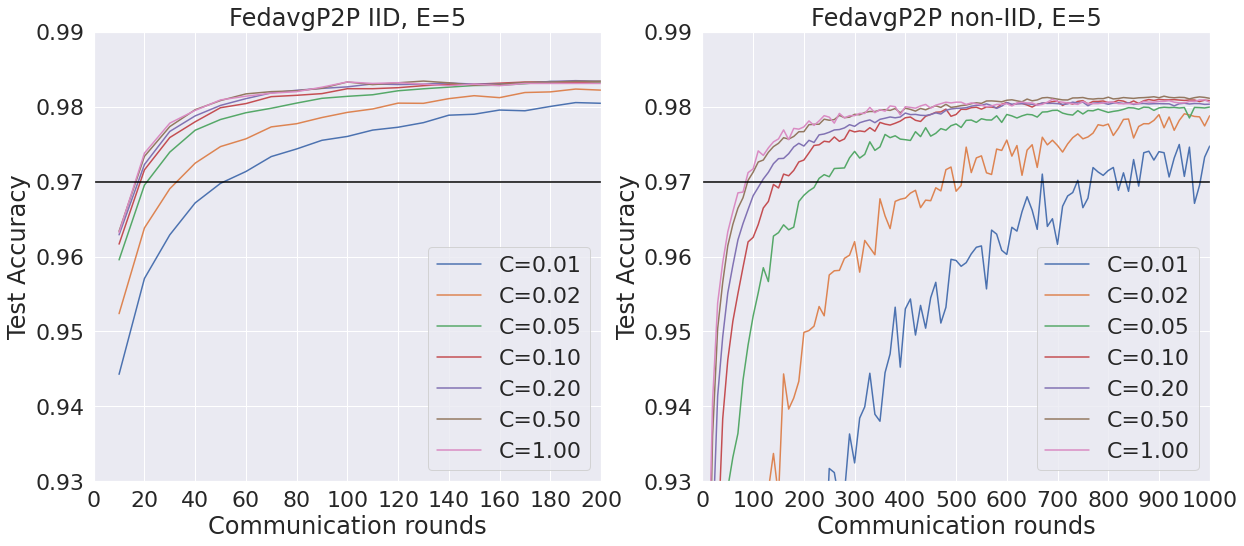

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import matplotlib.ticker as ticker
sns.set_theme(style="darkgrid")
sns.set(rc={'figure.figsize':(20,8.27)})
sns.set(font_scale=2)

C_all=[1, 2, 5, 10, 20, 50, 99]
dfs = []
for C in C_all:
    nr_clients = 100 ### NUMBER OF CLIENTS/ENTITIES
    client_epochs = 5   # Number of client epochs
    communication_rounds = 200  # Number of maximum communication rounds
    test_every_x_round = 10

    dir_str = '{}_{}_{}_{}_{}/'.format(nr_clients, C, client_epochs, communication_rounds, test_every_x_round)
    path = './Results/P2P_iid/' + dir_str

    with open(path + 'metrics', 'rb') as metrics_file:
        metrics_p2p = pickle.load(metrics_file)

    # per node communication
    # C*nr_clients*round

    avgs =  [calc_avg_clients_metrics(metrics_p2p[0][i]) for i in range(communication_rounds//test_every_x_round)]
    df_p2p = pd.DataFrame(avgs)
    # make_monotonic('average_accuracy', df_p2p)
    comm_round = [i for i in range(10,210,10)]
    sent_models_per_client = [C*i for i in range(10, 210, 10)]
    # neighbors * communication_round/epoch

    # 0 indexed
    df_p2p['comm_round'] = comm_round
    df_p2p['sent_models_per_client'] = sent_models_per_client
    df_p2p['network_load'] = [i*nr_clients*C for i in range(10, 210, 10)]
    # change columns to match centralized
    df_p2p.columns = ['accuracy', 'precision', 'recall', 'f1','loss', 'comm_round', 'sent_models_per_client', 'network_load']
    if C == 99:
        dfs.append(df_p2p.assign(Clients="C={}".format(1.0)))
    else:
        dfs.append(df_p2p.assign(Clients="C={}".format(C/100)))

concatenated = pd.concat(dfs)
fig, ax = plt.subplots(1,2)
graph = sns.lineplot(x="comm_round", y="accuracy", hue="Clients", data=concatenated, ax=ax[0])
graph.axhline(0.97, color='black')
handles, labels = graph.get_legend_handles_labels()
labels = add_trailing_zeros(labels)
graph.legend(handles=handles[:], labels=labels[:])
ax[0].set_xlim(0, 200)
ax[0].set_ylim(0.93, 0.99)
graph.xaxis.set_major_locator(ticker.MultipleLocator(20))
graph.set_title('FedavgP2P IID, E=5')
graph.set_xlabel('Communication rounds')
graph.set_ylabel('Test Accuracy')


dfs = []
for C in C_all:
    nr_clients = 100 ### NUMBER OF CLIENTS/ENTITIES
    client_epochs = 5   # Number of client epochs
    communication_rounds = 1000  # Number of maximum communication rounds
    test_every_x_round = 10

    dir_str = '{}_{}_{}_{}_{}/'.format(nr_clients, C, client_epochs, communication_rounds, test_every_x_round)
    path = './Results/P2P_non_iid/' + dir_str

    with open(path + 'metrics', 'rb') as metrics_file:
        metrics_p2p = pickle.load(metrics_file)

    # per node communication
    # C*nr_clients*round

    avgs =  [calc_avg_clients_metrics(metrics_p2p[0][i]) for i in range(communication_rounds//test_every_x_round)]
    df_p2p = pd.DataFrame(avgs)
    # make_monotonic('average_accuracy', df_p2p)
    comm_round = [i for i in range(10,1010,10)]
    sent_models_per_client = [C*i for i in range(10, 1010, 10)]
    # neighbors * communication_round/epoch

    # 0 indexed
    df_p2p['comm_round'] = comm_round
    df_p2p['sent_models_per_client'] = sent_models_per_client
    df_p2p['network_load'] = [i*nr_clients*C for i in range(10, 1010, 10)]
    # change columns to match centralized
    df_p2p.columns = ['accuracy', 'precision', 'recall', 'f1','loss', 'comm_round', 'sent_models_per_client', 'network_load']
    if C == 99:
        dfs.append(df_p2p.assign(Clients="C={}".format(1.0)))
    else:
        dfs.append(df_p2p.assign(Clients="C={}".format(C/100)))

concatenated = pd.concat(dfs)
graph = sns.lineplot(x="comm_round", y="accuracy", hue="Clients", data=concatenated, ax=ax[1])
graph.axhline(0.97, color='black')
handles, labels = graph.get_legend_handles_labels()
labels = add_trailing_zeros(labels)
graph.legend(handles=handles[:], labels=labels[:])

ax[1].set_xlim(0, 1000)
ax[1].set_ylim(0.93, 0.99)
graph.xaxis.set_major_locator(ticker.MultipleLocator(100))
graph.set_title('FedavgP2P non-IID, E=5')
graph.set_xlabel('Communication rounds')
graph.set_ylabel('Test Accuracy')


fig.savefig("FedavgP2PE5.png")

# P2P 10 epochs

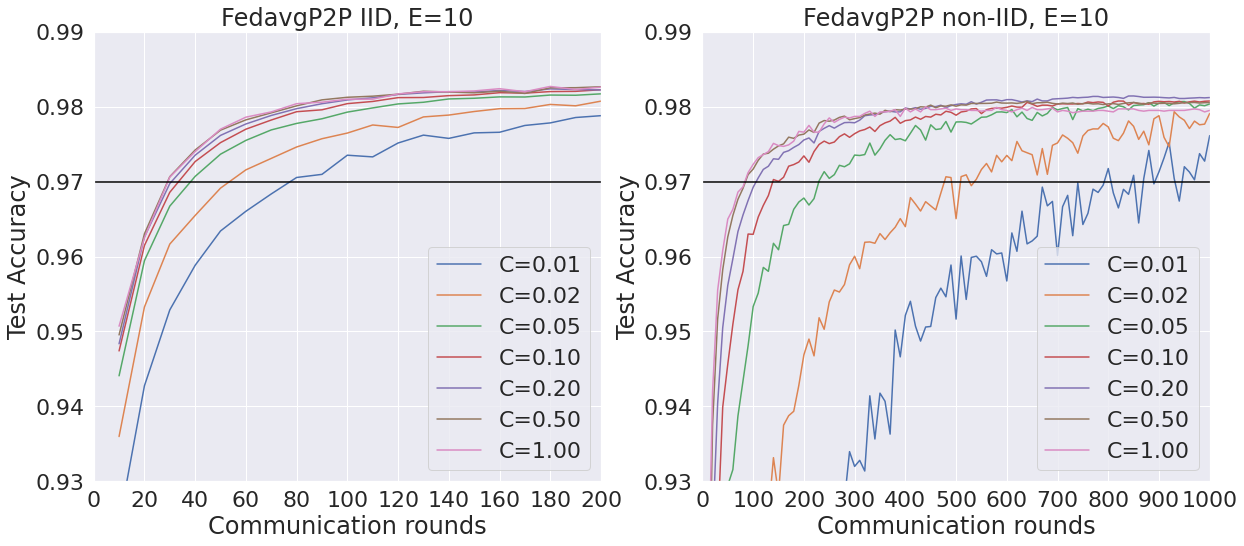

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import matplotlib.ticker as ticker
sns.set_theme(style="darkgrid")
sns.set(rc={'figure.figsize':(20,8.27)})
sns.set(font_scale=2)

C_all=[1, 2, 5, 10, 20, 50, 99]
dfs = []
for C in C_all:
    nr_clients = 100 ### NUMBER OF CLIENTS/ENTITIES
    client_epochs = 1   # Number of client epochs
    communication_rounds = 200  # Number of maximum communication rounds
    test_every_x_round = 10

    dir_str = '{}_{}_{}_{}_{}/'.format(nr_clients, C, client_epochs, communication_rounds, test_every_x_round)
    path = './Results/P2P_iid/' + dir_str

    with open(path + 'metrics', 'rb') as metrics_file:
        metrics_p2p = pickle.load(metrics_file)

    # per node communication
    # C*nr_clients*round

    avgs =  [calc_avg_clients_metrics(metrics_p2p[0][i]) for i in range(communication_rounds//test_every_x_round)]
    df_p2p = pd.DataFrame(avgs)
    # make_monotonic('average_accuracy', df_p2p)
    comm_round = [i for i in range(10,210,10)]
    sent_models_per_client = [C*i for i in range(10, 210, 10)]
    # neighbors * communication_round/epoch

    # 0 indexed
    df_p2p['comm_round'] = comm_round
    df_p2p['sent_models_per_client'] = sent_models_per_client
    df_p2p['network_load'] = [i*nr_clients*C for i in range(10, 210, 10)]
    # change columns to match centralized
    df_p2p.columns = ['accuracy', 'precision', 'recall', 'f1','loss', 'comm_round', 'sent_models_per_client', 'network_load']
    if C == 99:
        dfs.append(df_p2p.assign(Clients="C={}".format(1.0)))
    else:
        dfs.append(df_p2p.assign(Clients="C={}".format(C/100)))

concatenated = pd.concat(dfs)
fig, ax = plt.subplots(1,2)
graph = sns.lineplot(x="comm_round", y="accuracy", hue="Clients", data=concatenated, ax=ax[0])
graph.axhline(0.97, color='black')
handles, labels = graph.get_legend_handles_labels()
labels = add_trailing_zeros(labels)
graph.legend(handles=handles[:], labels=labels[:])
ax[0].set_xlim(0, 200)
ax[0].set_ylim(0.93, 0.99)
graph.xaxis.set_major_locator(ticker.MultipleLocator(20))
graph.set_title('FedavgP2P IID, E=10')
graph.set_xlabel('Communication rounds')
graph.set_ylabel('Test Accuracy')


dfs = []
for C in C_all:
    nr_clients = 100 ### NUMBER OF CLIENTS/ENTITIES
    client_epochs = 10   # Number of client epochs
    communication_rounds = 1000  # Number of maximum communication rounds
    test_every_x_round = 10

    dir_str = '{}_{}_{}_{}_{}/'.format(nr_clients, C, client_epochs, communication_rounds, test_every_x_round)
    path = './Results/P2P_non_iid/' + dir_str

    with open(path + 'metrics', 'rb') as metrics_file:
        metrics_p2p = pickle.load(metrics_file)

    # per node communication
    # C*nr_clients*round

    avgs =  [calc_avg_clients_metrics(metrics_p2p[0][i]) for i in range(communication_rounds//test_every_x_round)]
    df_p2p = pd.DataFrame(avgs)
    # make_monotonic('average_accuracy', df_p2p)
    comm_round = [i for i in range(10,1010,10)]
    sent_models_per_client = [C*i for i in range(10, 1010, 10)]
    # neighbors * communication_round/epoch

    # 0 indexed
    df_p2p['comm_round'] = comm_round
    df_p2p['sent_models_per_client'] = sent_models_per_client
    df_p2p['network_load'] = [i*nr_clients*C for i in range(10, 1010, 10)]
    # change columns to match centralized
    df_p2p.columns = ['accuracy', 'precision', 'recall', 'f1','loss', 'comm_round', 'sent_models_per_client', 'network_load']
    if C == 99:
        dfs.append(df_p2p.assign(Clients="C={}".format(1.0)))
    else:
        dfs.append(df_p2p.assign(Clients="C={}".format(C/100.0)))

concatenated = pd.concat(dfs)
graph = sns.lineplot(x="comm_round", y="accuracy", hue="Clients", data=concatenated, ax=ax[1])
graph.axhline(0.97, color='black')
handles, labels = graph.get_legend_handles_labels()
labels = add_trailing_zeros(labels)
graph.legend(handles=handles[:], labels=labels[:])
ax[1].set_xlim(0, 1000)
ax[1].set_ylim(0.93, 0.99)
graph.xaxis.set_major_locator(ticker.MultipleLocator(100))
graph.set_title('FedavgP2P non-IID, E=10')
graph.set_xlabel('Communication rounds')
graph.set_ylabel('Test Accuracy')



fig.savefig("FedavgP2PE10.png")

# Calculate threshold P2P

In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
#sns.set_theme(style="darkgrid")
sns.set(rc={'figure.figsize':(20,8.27)})
sns.set(font_scale=2)  # *crazy big

C_all=[1, 2, 5, 10, 20, 50]
dfs = []

# Key: C
# Value: per client communication
# when reached 97%
reach_threshhold = {'C': [], 'sent_models_per_client': [], 'network_load': [], 'comm_round': []}
for C in C_all:
    nr_clients = 100 ### NUMBER OF CLIENTS/ENTITIES
    
    client_epochs = 10   # Number of client epochs
    communication_rounds = 1000  # Number of maximum communication rounds
    test_every_x_round = 10

    dir_str = '{}_{}_{}_{}_{}/'.format(nr_clients, C, client_epochs, communication_rounds, test_every_x_round)
    path = './Results/P2P_non_iid/' + dir_str

    with open(path + 'metrics', 'rb') as metrics_file:
        metrics_p2p = pickle.load(metrics_file)

    avgs =  [calc_avg_clients_metrics(metrics_p2p[0][i]) for i in range(communication_rounds//test_every_x_round)]
    #print(avgs)
    # per node communication
    # C*nr_clients*round
    # Find when acc bigger than 97%
    for i, test_round in enumerate(avgs):
        #
        if test_round['average_accuracy'] >= 0.97:
            #print(test_round)
            #print(i)
            reach_threshhold['C'].append(C)
            reach_threshhold['sent_models_per_client'].append((i+1)*test_every_x_round*C)
            reach_threshhold['comm_round'].append((i+1)*test_every_x_round)
            reach_threshhold['network_load'].append((i+1)* test_every_x_round*nr_clients*C)
            break

print(reach_threshhold)
# df = pd.DataFrame(reach_threshhold)
# graph = sns.lineplot(x="neighbors", y="comm_round", data=df)
# graph.set_title("Reached average 97% f1score P2P models IID")

{'C': [1, 2, 5, 10, 20, 50], 'sent_models_per_client': [800, 960, 1150, 1400, 2200, 4500], 'network_load': [80000, 96000, 115000, 140000, 220000, 450000], 'comm_round': [800, 480, 230, 140, 110, 90]}


In [13]:
for x in reach_threshhold['comm_round']:
    print(740/x)

0.9487179487179487
1.510204081632653
2.740740740740741
4.625
6.166666666666667
8.222222222222221


Fedavg, FedavgP2P combo

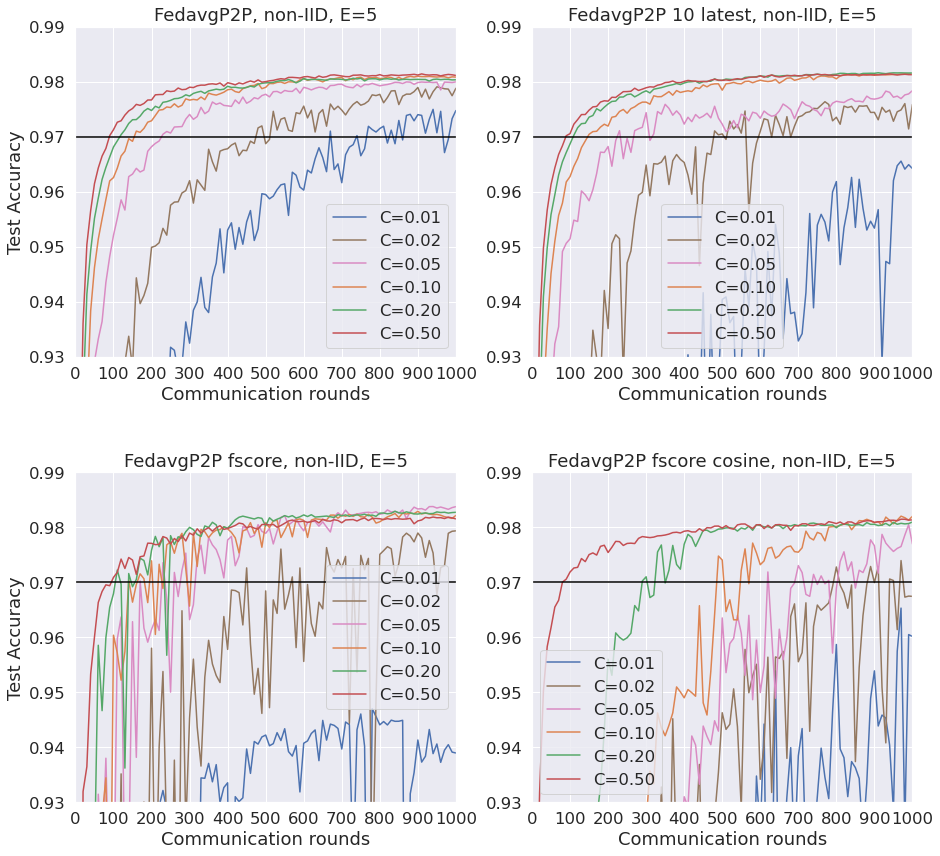

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import matplotlib.ticker as ticker
sns.set(rc={'figure.figsize':(15,14.27)})
sns.set(font_scale=1.5)
fig, ax = plt.subplots(2,2)
fig.subplots_adjust(hspace=0.35)

C_all=[1, 2, 5, 10, 20, 50]
dfs = []
for C in C_all:
    nr_clients = 100 ### NUMBER OF CLIENTS/ENTITIES
    client_epochs = 5   # Number of client epochs
    communication_rounds = 1000  # Number of maximum communication rounds
    test_every_x_round = 10

    dir_str = '{}_{}_{}_{}_{}/'.format(nr_clients, C, client_epochs, communication_rounds, test_every_x_round)
    path = './Results/P2P_non_iid/' + dir_str

    with open(path + 'metrics', 'rb') as metrics_file:
        metrics_p2p = pickle.load(metrics_file)

    # per node communication
    # C*nr_clients*round

    avgs =  [calc_avg_clients_metrics(metrics_p2p[0][i]) for i in range(communication_rounds//test_every_x_round)]
    df_p2p = pd.DataFrame(avgs)
    # make_monotonic('average_accuracy', df_p2p)
    comm_round = [i for i in range(10,1010,10)]
    sent_models_per_client = [C*i for i in range(10, 1010, 10)]
    # neighbors * communication_round/epoch

    # 0 indexed
    df_p2p['comm_round'] = comm_round
    df_p2p['sent_models_per_client'] = sent_models_per_client
    df_p2p['network_load'] = [i*nr_clients*C for i in range(10, 1010, 10)]
    # change columns to match centralized
    df_p2p.columns = ['accuracy', 'precision', 'recall', 'f1','loss', 'upper_2std', 'lower_2std', 'std', 'comm_round', 'sent_models_per_client', 'network_load', ]
    if C == 99:
        dfs.append(df_p2p.assign(Clients="C={}".format(1.0)))
    else:
        dfs.append(df_p2p.assign(Clients="C={}".format(C/100)))

concatenated = pd.concat(dfs)
graph = sns.lineplot(x="comm_round", y="accuracy", hue="Clients", data=concatenated, ax=ax[0][0], palette=['C0', 'C5', 'C6', 'C1', 'C2', 'C3',])
graph.axhline(0.97, color='black')
handles, labels = graph.get_legend_handles_labels()
labels = add_trailing_zeros(labels)
graph.legend(handles=handles[:], labels=labels[:])

ax[0][0].set_xlim(0, 1000)
ax[0][0].set_ylim(0.93, 0.99)
graph.xaxis.set_major_locator(ticker.MultipleLocator(100))
graph.set_title('FedavgP2P, non-IID, E=5')
graph.set_xlabel('Communication rounds')
graph.set_ylabel('Test Accuracy')

######################################################################################################################
 
C_all=[1, 2, 5, 10, 20, 50]
dfs = []
for C in C_all:
    nr_clients = 100 ### NUMBER OF CLIENTS/ENTITIES
    client_epochs = 5   # Number of client epochs
    communication_rounds = 1000  # Number of maximum communication rounds
    test_every_x_round = 10

    dir_str = '{}_{}_{}_{}_{}/'.format(nr_clients, C, client_epochs, communication_rounds, test_every_x_round)
    path = './Results/P2P_heur_non_iid/' + dir_str

    with open(path + 'metrics', 'rb') as metrics_file:
        metrics_p2p = pickle.load(metrics_file)

    # per node communication
    # C*nr_clients*round

    avgs =  [calc_avg_clients_metrics(metrics_p2p[0][i]) for i in range(communication_rounds//test_every_x_round)]
    df_p2p = pd.DataFrame(avgs)
    # make_monotonic('average_accuracy', df_p2p)
    comm_round = [i for i in range(10,1010,10)]
    sent_models_per_client = [C*i for i in range(10, 1010, 10)]
    # neighbors * communication_round/epoch

    # 0 indexed
    df_p2p['comm_round'] = comm_round
    df_p2p['sent_models_per_client'] = sent_models_per_client
    df_p2p['network_load'] = [i*nr_clients*C for i in range(10, 1010, 10)]
    # change columns to match centralized
    df_p2p.columns = ['accuracy', 'precision', 'recall', 'f1','loss', 'upper_2std', 'lower_2std', 'std', 'comm_round', 'sent_models_per_client', 'network_load', ]
    if C == 99:
        dfs.append(df_p2p.assign(Clients="C={}".format(1.0)))
    else:
        dfs.append(df_p2p.assign(Clients="C={}".format(C/100)))

concatenated = pd.concat(dfs)
graph = sns.lineplot(x="comm_round", y="accuracy", hue="Clients", data=concatenated, ax=ax[0][1], palette=['C0', 'C5', 'C6', 'C1', 'C2', 'C3',])
graph.axhline(0.97, color='black')
handles, labels = graph.get_legend_handles_labels()
labels = add_trailing_zeros(labels)
graph.legend(handles=handles[:], labels=labels[:])

ax[0][1].set_xlim(0, 1000)
ax[0][1].set_ylim(0.93, 0.99)
graph.xaxis.set_major_locator(ticker.MultipleLocator(100))
graph.set_title('FedavgP2P 10 latest, non-IID, E=5')
graph.set_xlabel('Communication rounds')
graph.set_ylabel('')

######################################################################################################################
 
C_all=[1, 2, 5, 10, 20, 50]
dfs = []
for C in C_all:
    nr_clients = 100 ### NUMBER OF CLIENTS/ENTITIES
    client_epochs = 5   # Number of client epochs
    communication_rounds = 1000  # Number of maximum communication rounds
    test_every_x_round = 10

    dir_str = '{}_{}_{}_{}_{}/'.format(nr_clients, C, client_epochs, communication_rounds, test_every_x_round)
    path = './Results/P2P_acc_non_iid_2/' + dir_str

    with open(path + 'metrics', 'rb') as metrics_file:
        metrics_p2p = pickle.load(metrics_file)

    # per node communication
    # C*nr_clients*round

    avgs =  [calc_avg_clients_metrics(metrics_p2p[0][i]) for i in range(communication_rounds//test_every_x_round)]
    df_p2p = pd.DataFrame(avgs)
    # make_monotonic('average_accuracy', df_p2p)
    comm_round = [i for i in range(10,1010,10)]
    sent_models_per_client = [C*i for i in range(10, 1010, 10)]
    # neighbors * communication_round/epoch

    # 0 indexed
    df_p2p['comm_round'] = comm_round
    df_p2p['sent_models_per_client'] = sent_models_per_client
    df_p2p['network_load'] = [i*nr_clients*C for i in range(10, 1010, 10)]
    # change columns to match centralized
    df_p2p.columns = ['accuracy', 'precision', 'recall', 'f1','loss', 'upper_2std', 'lower_2std', 'std', 'comm_round', 'sent_models_per_client', 'network_load', ]
    if C == 99:
        dfs.append(df_p2p.assign(Clients="C={}".format(1.0)))
    else:
        dfs.append(df_p2p.assign(Clients="C={}".format(C/100)))

concatenated = pd.concat(dfs)
graph = sns.lineplot(x="comm_round", y="accuracy", hue="Clients", data=concatenated, ax=ax[1][0], palette=['C0', 'C5', 'C6', 'C1', 'C2', 'C3',])
graph.axhline(0.97, color='black')
handles, labels = graph.get_legend_handles_labels()
labels = add_trailing_zeros(labels)
graph.legend(handles=handles[:], labels=labels[:])

ax[1][0].set_xlim(0, 1000)
ax[1][0].set_ylim(0.93, 0.99)
graph.xaxis.set_major_locator(ticker.MultipleLocator(100))
graph.set_title('FedavgP2P fscore, non-IID, E=5')
graph.set_xlabel('Communication rounds')
graph.set_ylabel('Test Accuracy')

########################################################################
C_all=[1, 2, 5, 10, 20, 50]
dfs = []
for C in C_all:
    nr_clients = 100 ### NUMBER OF CLIENTS/ENTITIES
    client_epochs = 5   # Number of client epochs
    communication_rounds = 1000  # Number of maximum communication rounds
    test_every_x_round = 10

    dir_str = '{}_{}_{}_{}_{}/'.format(nr_clients, C, client_epochs, communication_rounds, test_every_x_round)
    path = './Results/P2P_cosine_non_iid/' + dir_str

    with open(path + 'metrics', 'rb') as metrics_file:
        metrics_p2p = pickle.load(metrics_file)

    # per node communication
    # C*nr_clients*round

    avgs =  [calc_avg_clients_metrics(metrics_p2p[0][i]) for i in range(communication_rounds//test_every_x_round)]
    df_p2p = pd.DataFrame(avgs)
    # make_monotonic('average_accuracy', df_p2p)
    comm_round = [i for i in range(10,1010,10)]
    sent_models_per_client = [C*i for i in range(10, 1010, 10)]
    # neighbors * communication_round/epoch

    # 0 indexed
    df_p2p['comm_round'] = comm_round
    df_p2p['sent_models_per_client'] = sent_models_per_client
    df_p2p['network_load'] = [i*nr_clients*C for i in range(10, 1010, 10)]
    # change columns to match centralized
    df_p2p.columns = ['accuracy', 'precision', 'recall', 'f1','loss', 'upper_2std', 'lower_2std', 'std', 'comm_round', 'sent_models_per_client', 'network_load', ]
    if C == 99:
        dfs.append(df_p2p.assign(Clients="C={}".format(1.0)))
    else:
        dfs.append(df_p2p.assign(Clients="C={}".format(C/100)))

concatenated = pd.concat(dfs)
graph = sns.lineplot(x="comm_round", y="accuracy", hue="Clients", data=concatenated, ax=ax[1][1], palette=['C0', 'C5', 'C6', 'C1', 'C2', 'C3',])
graph.axhline(0.97, color='black')
handles, labels = graph.get_legend_handles_labels()
labels = add_trailing_zeros(labels)
graph.legend(handles=handles[:], labels=labels[:])

ax[1][1].set_xlim(0, 1000)
ax[1][1].set_ylim(0.93, 0.99)
graph.xaxis.set_major_locator(ticker.MultipleLocator(100))
graph.set_title('FedavgP2P fscore cosine, non-IID, E=5')
graph.set_xlabel('Communication rounds')
graph.set_ylabel('')

fig.savefig("P2Pstrats.png")

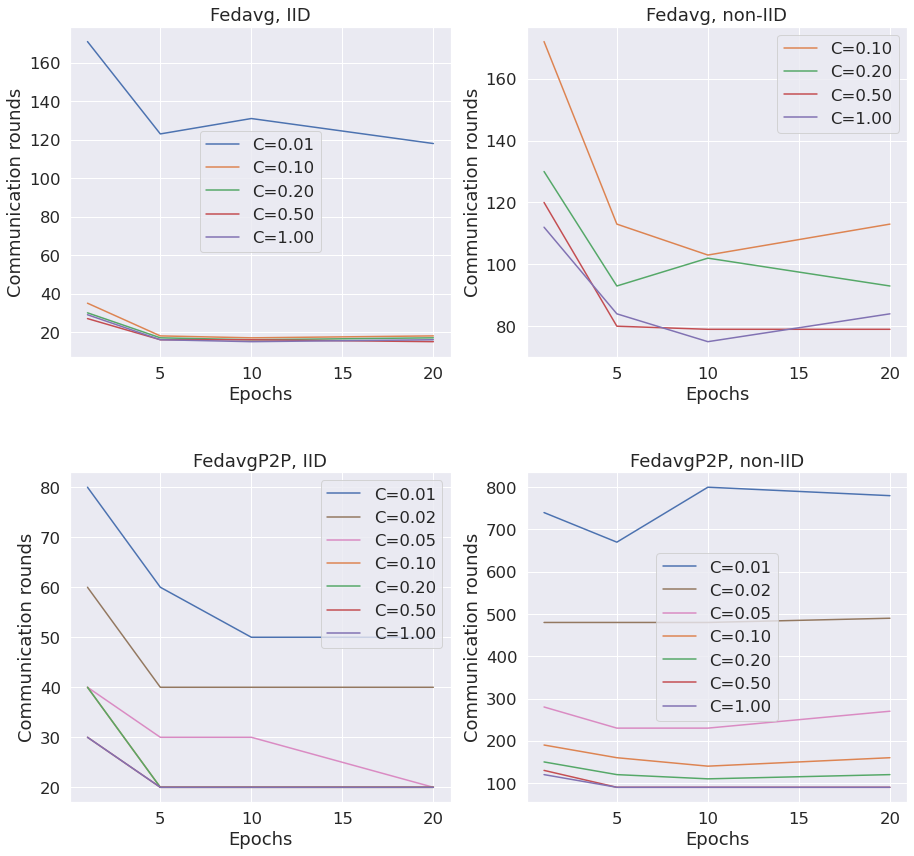

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import matplotlib.ticker as ticker
sns.set_theme(style="darkgrid")
sns.set(rc={'figure.figsize':(15,14.27)})
sns.set(font_scale=1.5)
fig, ax = plt.subplots(2,2)
fig.subplots_adjust(hspace=0.35)
#concatenated = pd.concat(dfs)

### FedavgP2P IID
graph = sns.lineplot(y=[171, 123, 131, 118], x=[1, 5, 10, 20], label="C=0.01", ax=ax[0][0], color='C0')
graph = sns.lineplot(y=[35, 18, 17, 18], x=[1, 5, 10, 20], label="C=0.10", ax=ax[0][0], color='C1')
graph = sns.lineplot(y=[30, 17, 16, 17], x=[1, 5, 10, 20], label="C=0.20", ax=ax[0][0], color='C2')
graph = sns.lineplot(y=[27, 16, 16, 15], x=[1, 5, 10, 20], label="C=0.50", ax=ax[0][0], color='C3')
graph = sns.lineplot(y=[29, 16, 15, 16], x=[1, 5, 10, 20], label="C=1.00", ax=ax[0][0], color='C4')
graph.xaxis.set_major_locator(ticker.MultipleLocator(5))
graph.set_title('Fedavg, IID')
graph.set_xlabel('Epochs')
graph.set_ylabel('Communication rounds')


### FedavgP2P IID
#graph = sns.lineplot(y=[1649], x=[1,], label="C=0.01", ax=ax[0][1], color='C0')
graph = sns.lineplot(y=[172, 113, 103, 113], x=[1, 5, 10, 20], label="C=0.10", ax=ax[0][1], color='C1')
graph = sns.lineplot(y=[130, 93, 102, 93], x=[1, 5, 10, 20], label="C=0.20", ax=ax[0][1], color='C2')
graph = sns.lineplot(y=[120, 80, 79, 79], x=[1, 5, 10, 20], label="C=0.50", ax=ax[0][1], color='C3')
graph = sns.lineplot(y=[112, 84, 75, 84], x=[1, 5, 10, 20], label="C=1.00", ax=ax[0][1], color='C4')
graph.xaxis.set_major_locator(ticker.MultipleLocator(5))
graph.set_title('Fedavg, non-IID')
graph.set_xlabel('Epochs')
graph.set_ylabel('Communication rounds')


### FedavgP2P IID
graph = sns.lineplot(y=[80, 60, 50, 50], x=[1, 5, 10, 20], label="C=0.01", ax=ax[1][0], color='C0')
graph = sns.lineplot(y=[60, 40, 40, 40], x=[1, 5, 10, 20], label="C=0.02", ax=ax[1][0], color="C5")
graph = sns.lineplot(y=[40, 30, 30, 20], x=[1, 5, 10, 20], label="C=0.05", ax=ax[1][0], color='C6')
graph = sns.lineplot(y=[40, 20, 20, 20], x=[1, 5, 10, 20], label="C=0.10", ax=ax[1][0], color='C1')
graph = sns.lineplot(y=[40, 20, 20, 20], x=[1, 5, 10, 20], label="C=0.20", ax=ax[1][0], color='C2')
graph = sns.lineplot(y=[30, 20, 20, 20], x=[1, 5, 10, 20], label="C=0.50", ax=ax[1][0], color='C3')
graph = sns.lineplot(y=[30, 20, 20, 20], x=[1, 5, 10, 20], label="C=1.00", ax=ax[1][0], color='C4')
graph.xaxis.set_major_locator(ticker.MultipleLocator(5))
graph.set_title('FedavgP2P, IID')
graph.set_xlabel('Epochs')
graph.set_ylabel('Communication rounds')

### FedavgP2P non-IID
graph = sns.lineplot(y=[740,670,800, 780], x=[1, 5, 10, 20], label="C=0.01", ax=ax[1][1], color='C0')
graph = sns.lineplot(y=[480, 480, 480, 490], x=[1, 5, 10, 20], label="C=0.02", ax=ax[1][1], color="C5")
graph = sns.lineplot(y=[280, 230, 230, 270], x=[1, 5, 10, 20], label="C=0.05", ax=ax[1][1], color='C6')
graph = sns.lineplot(y=[190, 160, 140, 160], x=[1, 5, 10, 20], label="C=0.10", ax=ax[1][1], color='C1')
graph = sns.lineplot(y=[150, 120, 110, 120], x=[1, 5, 10, 20], label="C=0.20", ax=ax[1][1], color='C2')
graph = sns.lineplot(y=[130, 90, 90, 90], x=[1, 5, 10, 20], label="C=0.50", ax=ax[1][1], color='C3')
graph = sns.lineplot(y=[120, 90, 90, 90], x=[1, 5, 10, 20], label="C=1.00", ax=ax[1][1], color='C4')
graph.xaxis.set_major_locator(ticker.MultipleLocator(5))
graph.set_title('FedavgP2P, non-IID')
graph.set_xlabel('Epochs')
graph.set_ylabel('Communication rounds')



fig.savefig("Epochs.png")

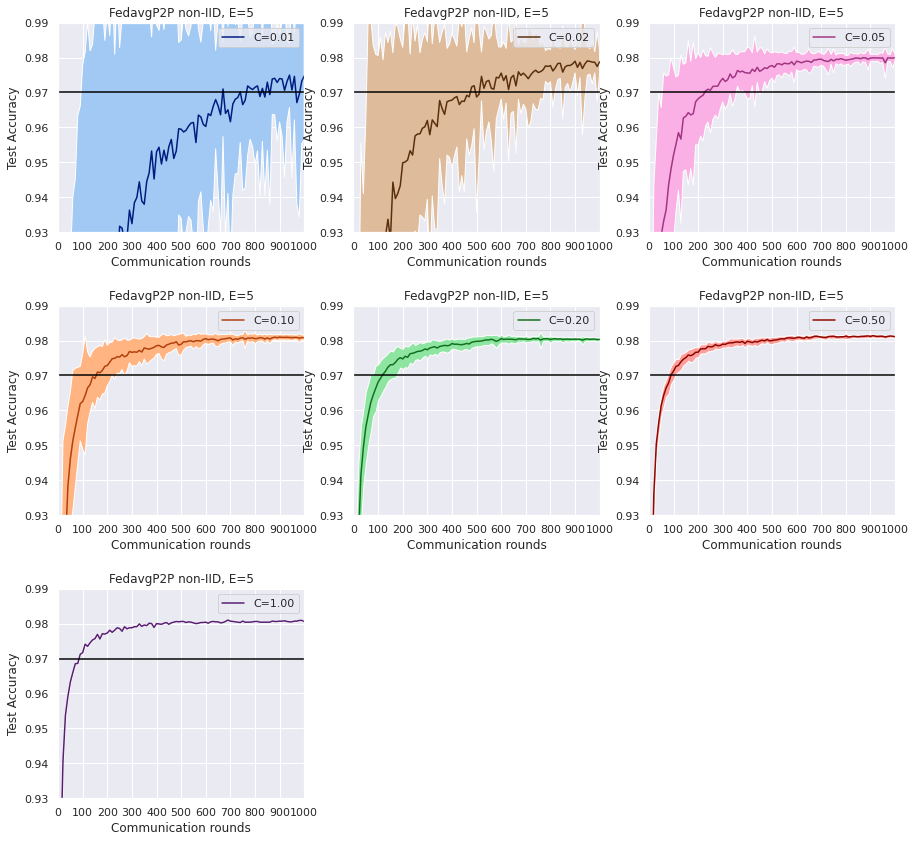

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import matplotlib.ticker as ticker
sns.set_theme(style="darkgrid")
sns.set(rc={'figure.figsize':(15,14.27)})
sns.set(font_scale=1)
fig, ax = plt.subplots(3,3)
fig.subplots_adjust(hspace=0.35)

C_all=[1]
dfs = []
for C in C_all:
    nr_clients = 100 ### NUMBER OF CLIENTS/ENTITIES
    client_epochs = 5   # Number of client epochs
    communication_rounds = 1000  # Number of maximum communication rounds
    test_every_x_round = 10

    dir_str = '{}_{}_{}_{}_{}/'.format(nr_clients, C, client_epochs, communication_rounds, test_every_x_round)
    path = './Results/P2P_non_iid/' + dir_str

    with open(path + 'metrics', 'rb') as metrics_file:
        metrics_p2p = pickle.load(metrics_file)

    # per node communication
    # C*nr_clients*round

    avgs =  [calc_avg_clients_metrics(metrics_p2p[0][i]) for i in range(communication_rounds//test_every_x_round)]
    df_p2p = pd.DataFrame(avgs)
    # make_monotonic('average_accuracy', df_p2p)
    comm_round = [i for i in range(10,1010,10)]
    sent_models_per_client = [C*i for i in range(10, 1010, 10)]
    # neighbors * communication_round/epoch

    # 0 indexed
    df_p2p['comm_round'] = comm_round
    df_p2p['sent_models_per_client'] = sent_models_per_client
    df_p2p['network_load'] = [i*nr_clients*C for i in range(10, 1010, 10)]
    # change columns to match centralized
    df_p2p.columns = ['accuracy', 'precision', 'recall', 'f1','loss', 'upper_2std', 'lower_2std', 'std', 'comm_round', 'sent_models_per_client', 'network_load', ]
    if C == 99:
        dfs.append(df_p2p.assign(Clients="C={}".format(1.0)))
    else:
        dfs.append(df_p2p.assign(Clients="C={}".format(C/100)))

concatenated = pd.concat(dfs)
graph = sns.lineplot(x="comm_round", y="accuracy", hue="Clients", data=concatenated, ax=ax[0][0], palette=[sns.color_palette("dark")[0]])
ax[0][0].fill_between(df_p2p["comm_round"], df_p2p["upper_2std"], df_p2p["lower_2std"], facecolor=sns.color_palette('pastel')[0])
graph.axhline(0.97, color='black')
handles, labels = graph.get_legend_handles_labels()
labels = add_trailing_zeros(labels)
graph.legend(handles=handles[:], labels=labels[:])

ax[0][0].set_xlim(0, 1000)
ax[0][0].set_ylim(0.93, 0.99)
graph.xaxis.set_major_locator(ticker.MultipleLocator(100))
graph.set_title('FedavgP2P non-IID, E=5')
graph.set_xlabel('Communication rounds')
graph.set_ylabel('Test Accuracy')



def plot(C_all, x, y, color, color2):
    dfs = []
    for C in C_all:
        nr_clients = 100 ### NUMBER OF CLIENTS/ENTITIES
        client_epochs = 5   # Number of client epochs
        communication_rounds = 1000  # Number of maximum communication rounds
        test_every_x_round = 10

        dir_str = '{}_{}_{}_{}_{}/'.format(nr_clients, C, client_epochs, communication_rounds, test_every_x_round)
        path = './Results/P2P_non_iid/' + dir_str

        with open(path + 'metrics', 'rb') as metrics_file:
            metrics_p2p = pickle.load(metrics_file)

        # per node communication
        # C*nr_clients*round

        avgs =  [calc_avg_clients_metrics(metrics_p2p[0][i]) for i in range(communication_rounds//test_every_x_round)]
        df_p2p = pd.DataFrame(avgs)
        # make_monotonic('average_accuracy', df_p2p)
        comm_round = [i for i in range(10,1010,10)]
        sent_models_per_client = [C*i for i in range(10, 1010, 10)]
        # neighbors * communication_round/epoch

        # 0 indexed
        df_p2p['comm_round'] = comm_round
        df_p2p['sent_models_per_client'] = sent_models_per_client
        df_p2p['network_load'] = [i*nr_clients*C for i in range(10, 1010, 10)]
        # change columns to match centralized
        df_p2p.columns = ['accuracy', 'precision', 'recall', 'f1','loss', 'upper_2std', 'lower_2std', 'std', 'comm_round', 'sent_models_per_client', 'network_load', ]
        if C == 99:
            dfs.append(df_p2p.assign(Clients="C={}".format(1.0)))
        else:
            dfs.append(df_p2p.assign(Clients="C={}".format(C/100)))

    concatenated = pd.concat(dfs)
    graph = sns.lineplot(x="comm_round", y="accuracy", hue="Clients", data=concatenated, ax=ax[x][y], palette=[color])
    #graph = sns.lineplot(x="comm_round", y="upper_2std", data=concatenated, ax=ax[x][y], color="red")
    #graph = sns.lineplot(x="comm_round", y="lower_2std", data=concatenated, ax=ax[x][y], color="red")
    ax[x][y].fill_between(df_p2p["comm_round"], df_p2p["upper_2std"], df_p2p["lower_2std"], facecolor=color2)
    graph.axhline(0.97, color='black')
    handles, labels = graph.get_legend_handles_labels()
    labels = add_trailing_zeros(labels)
    graph.legend(handles=handles[:], labels=labels[:])

    ax[x][y].set_xlim(0, 1000)
    ax[x][y].set_ylim(0.93, 0.99)
    graph.xaxis.set_major_locator(ticker.MultipleLocator(100))
    graph.set_title('FedavgP2P non-IID, E=5')
    graph.set_xlabel('Communication rounds')
    graph.set_ylabel('Test Accuracy')

plot([2], 0, 1, sns.color_palette("dark")[5] ,sns.color_palette('pastel')[5])
plot([5], 0, 2, sns.color_palette("dark")[6] ,sns.color_palette('pastel')[6])
plot([10], 1, 0,sns.color_palette("dark")[1] ,sns.color_palette('pastel')[1])
plot([20], 1, 1,sns.color_palette("dark")[2] ,sns.color_palette('pastel')[2])
plot([50], 1, 2,sns.color_palette("dark")[3] ,sns.color_palette('pastel')[3])
plot([99], 2, 0,sns.color_palette("dark")[4] ,sns.color_palette('pastel')[4])
ax[2][1].set_visible(False)
ax[2][2].set_visible(False)

fig.savefig("FedavgP2PE5.png")

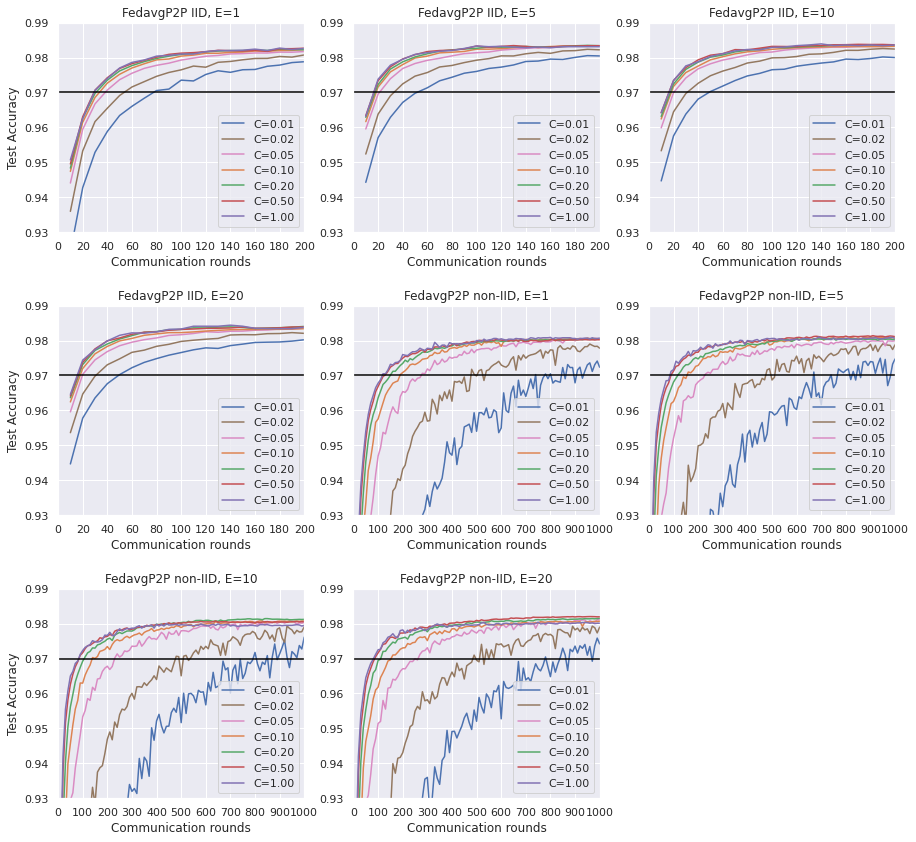

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import matplotlib.ticker as ticker
sns.set_theme(style="darkgrid")
sns.set(rc={'figure.figsize':(15,14.27)})
sns.set(font_scale=1)
fig, ax = plt.subplots(3,3)
fig.subplots_adjust(hspace=0.35)

palette_p2p = [sns.color_palette()[0], sns.color_palette()[5], sns.color_palette()[6], sns.color_palette()[1], sns.color_palette()[2], sns.color_palette()[3], sns.color_palette()[4]]


def plot_fedavg(x, y, E):
    dfs = []
    C_all=[1, 10, 20, 50, 100]
    for C in C_all:
        nr_clients = 100 ### NUMBER OF CLIENTS/ENTITIES
        client_epochs = E   # Number of client epochs
        communication_rounds = 1000  # Number of maximum communication rounds
        if C == 1 and E == 1:
            communication_rounds=4000
        test_every_x_round = 1

        dir_str = '{}_{}_{}_{}_{}/'.format(nr_clients, C, client_epochs, communication_rounds, test_every_x_round)
        path = './Results/Fedavg_non_iid/' + dir_str

        with open(path + 'metrics', 'rb') as metrics_file:
            metrics = pickle.load(metrics_file)

        df = pd.DataFrame.from_dict(metrics[0])
        df.drop(columns=["classification_report"])
        # make_monotonic('accuracy', df)
        df["comm_round"] = [i+1 for i in range(communication_rounds)]
        df['sent_models_per_client'] = [i+1 for i in range(communication_rounds)]
        df['network_load'] = [(i+1)*(C*2) for i in range(communication_rounds)]
        dfs.append(df.assign(Clients="C={}".format(C/100)))

    concatenated = pd.concat(dfs)
    graph = sns.lineplot(x="comm_round", y="accuracy", hue="Clients", data=concatenated, ax=ax[x][y], palette=sns.color_palette()[:5])
    graph.axhline(0.97, color='black')
    handles, labels = graph.get_legend_handles_labels()
    labels = add_trailing_zeros(labels)
    graph.legend(handles=handles[:], labels=labels[:])
    ax[x][y].set_xlim(0, 1000)
    ax[x][y].set_ylim(0.93, 0.99)
    graph.xaxis.set_major_locator(ticker.MultipleLocator(100))
    graph.set_title('Fedavg non-IID, E={}'.format(E))
    graph.set_xlabel('Communication rounds')
    if y_label:
        graph.set_ylabel('Test Accuracy')
    else:
        graph.set_ylabel('')

###############################################################################################

def plot_p2p(x, y, E, y_label):
    C_all=[1, 2, 5, 10, 20, 50, 99]
    dfs = []
    for C in C_all:
        nr_clients = 100 ### NUMBER OF CLIENTS/ENTITIES
        client_epochs = E   # Number of client epochs
        communication_rounds = 1000  # Number of maximum communication rounds
        test_every_x_round = 10

        dir_str = '{}_{}_{}_{}_{}/'.format(nr_clients, C, client_epochs, communication_rounds, test_every_x_round)
        path = './Results/P2P_non_iid/' + dir_str

        with open(path + 'metrics', 'rb') as metrics_file:
            metrics_p2p = pickle.load(metrics_file)

        # per node communication
        # C*nr_clients*round

        avgs =  [calc_avg_clients_metrics(metrics_p2p[0][i]) for i in range(communication_rounds//test_every_x_round)]
        df_p2p = pd.DataFrame(avgs)
        # make_monotonic('average_accuracy', df_p2p)
        comm_round = [i for i in range(10,1010,10)]
        sent_models_per_client = [C*i for i in range(10, 1010, 10)]
        # neighbors * communication_round/epoch

        # 0 indexed
        df_p2p['comm_round'] = comm_round
        df_p2p['sent_models_per_client'] = sent_models_per_client
        df_p2p['network_load'] = [i*nr_clients*C for i in range(10, 1010, 10)]
        # change columns to match centralized
        df_p2p.columns = ['accuracy', 'precision', 'recall', 'f1','loss', 'upper_2std', 'lower_2std', 'std', 'comm_round', 'sent_models_per_client', 'network_load', ]
        if C == 99:
            dfs.append(df_p2p.assign(Clients="C={}".format(1.0)))
        else:
            dfs.append(df_p2p.assign(Clients="C={}".format(C/100)))

    concatenated = pd.concat(dfs)
    graph = sns.lineplot(x="comm_round", y="accuracy", hue="Clients", data=concatenated, ax=ax[x][y], palette=palette_p2p)
    graph.axhline(0.97, color='black')
    handles, labels = graph.get_legend_handles_labels()
    labels = add_trailing_zeros(labels)
    graph.legend(handles=handles[:], labels=labels[:])

    ax[x][y].set_xlim(0, 1000)
    ax[x][y].set_ylim(0.93, 0.99)
    graph.xaxis.set_major_locator(ticker.MultipleLocator(100))
    graph.set_title('FedavgP2P non-IID, E={}'.format(E))
    graph.set_xlabel('Communication rounds')
    if y_label:
        graph.set_ylabel('Test Accuracy')
    else:
        graph.set_ylabel('')

def plot_p2p_iid(x, y, E, y_label):
    C_all=[1, 2, 5, 10, 20, 50, 99]
    dfs = []
    for C in C_all:
        nr_clients = 100 ### NUMBER OF CLIENTS/ENTITIES
        client_epochs = E   # Number of client epochs
        communication_rounds = 200  # Number of maximum communication rounds
        test_every_x_round = 10

        dir_str = '{}_{}_{}_{}_{}/'.format(nr_clients, C, client_epochs, communication_rounds, test_every_x_round)
        path = './Results/P2P_iid/' + dir_str

        with open(path + 'metrics', 'rb') as metrics_file:
            metrics_p2p = pickle.load(metrics_file)

        # per node communication
        # C*nr_clients*round

        avgs =  [calc_avg_clients_metrics(metrics_p2p[0][i]) for i in range(communication_rounds//test_every_x_round)]
        df_p2p = pd.DataFrame(avgs)
        # make_monotonic('average_accuracy', df_p2p)
        comm_round = [i for i in range(10,210,10)]
        sent_models_per_client = [C*i for i in range(10, 210, 10)]
        # neighbors * communication_round/epoch

        # 0 indexed
        df_p2p['comm_round'] = comm_round
        df_p2p['sent_models_per_client'] = sent_models_per_client
        df_p2p['network_load'] = [i*nr_clients*C for i in range(10, 210, 10)]
        # change columns to match centralized
        df_p2p.columns = ['accuracy', 'precision', 'recall', 'f1','loss', 'upper_2std', 'lower_2std', 'std', 'comm_round', 'sent_models_per_client', 'network_load', ]
        if C == 99:
            dfs.append(df_p2p.assign(Clients="C={}".format(1.0)))
        else:
            dfs.append(df_p2p.assign(Clients="C={}".format(C/100)))

    concatenated = pd.concat(dfs)
    graph = sns.lineplot(x="comm_round", y="accuracy", hue="Clients", data=concatenated, ax=ax[x][y], palette=palette_p2p)
    graph.axhline(0.97, color='black')
    handles, labels = graph.get_legend_handles_labels()
    labels = add_trailing_zeros(labels)
    graph.legend(handles=handles[:], labels=labels[:])
    ax[x][y].set_xlim(0, 200)
    ax[x][y].set_ylim(0.93, 0.99)
    graph.xaxis.set_major_locator(ticker.MultipleLocator(20))
    graph.set_title('FedavgP2P IID, E={}'.format(E))
    graph.set_xlabel('Communication rounds')
    if y_label:
        graph.set_ylabel('Test Accuracy')
    else:
        graph.set_ylabel('')
plot_p2p_iid(0, 0, 1, True)
plot_p2p_iid(0, 1, 5, False)
plot_p2p_iid(0, 2, 10, False)
plot_p2p_iid(1, 0, 20, True)
plot_p2p(1, 1, 1, False)
plot_p2p(1, 2, 5, False)
plot_p2p(2, 0, 10, True)
plot_p2p(2, 1, 20, False)

ax[2][2].set_visible(False) 

fig.savefig("P2Pall.png")

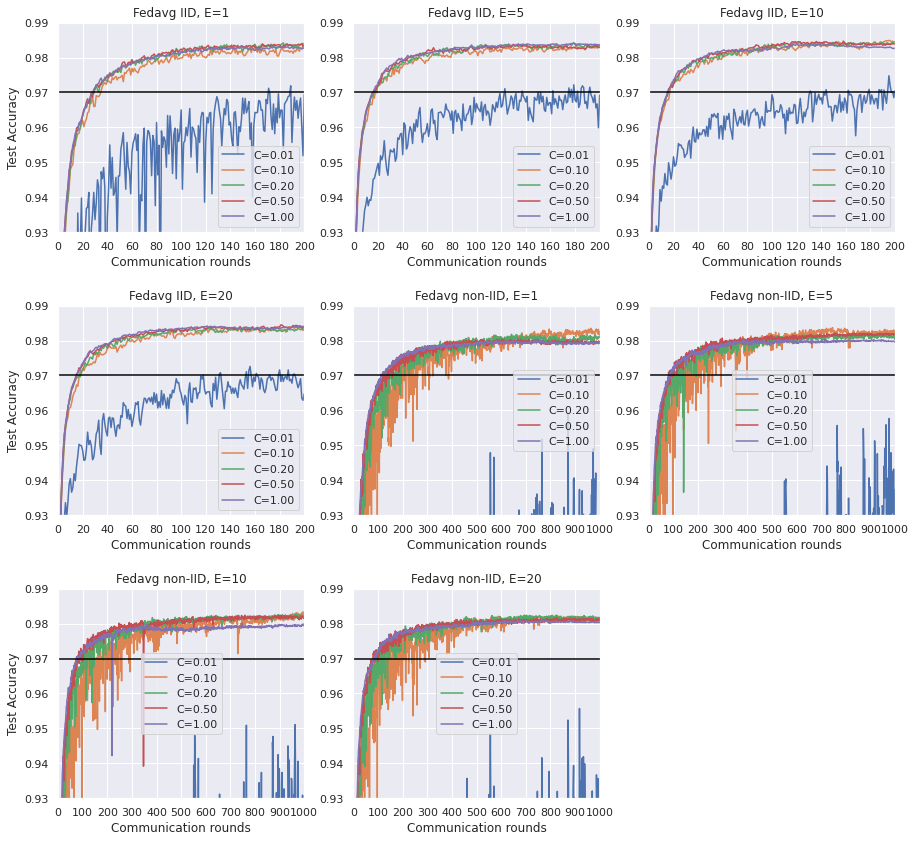

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import matplotlib.ticker as ticker
sns.set_theme(style="darkgrid")
sns.set(rc={'figure.figsize':(15,14.27)})
sns.set(font_scale=1)
fig, ax = plt.subplots(3,3)
fig.subplots_adjust(hspace=0.35)

palette_p2p = [sns.color_palette()[0], sns.color_palette()[5], sns.color_palette()[6], sns.color_palette()[1], sns.color_palette()[2], sns.color_palette()[3], sns.color_palette()[4]]


def plot_fedavg(x, y, E, y_label):
    dfs = []
    C_all=[1, 10, 20, 50, 100]
    for C in C_all:
        nr_clients = 100 ### NUMBER OF CLIENTS/ENTITIES
        client_epochs = E   # Number of client epochs
        communication_rounds = 1000  # Number of maximum communication rounds
        if C == 1 and E == 1:
            communication_rounds=4000
        test_every_x_round = 1

        dir_str = '{}_{}_{}_{}_{}/'.format(nr_clients, C, client_epochs, communication_rounds, test_every_x_round)
        path = './Results/Fedavg_non_iid/' + dir_str

        with open(path + 'metrics', 'rb') as metrics_file:
            metrics = pickle.load(metrics_file)

        df = pd.DataFrame.from_dict(metrics[0])
        df.drop(columns=["classification_report"])
        # make_monotonic('accuracy', df)
        df["comm_round"] = [i+1 for i in range(communication_rounds)]
        df['sent_models_per_client'] = [i+1 for i in range(communication_rounds)]
        df['network_load'] = [(i+1)*(C*2) for i in range(communication_rounds)]
        dfs.append(df.assign(Clients="C={}".format(C/100)))

    concatenated = pd.concat(dfs)
    graph = sns.lineplot(x="comm_round", y="accuracy", hue="Clients", data=concatenated, ax=ax[x][y], palette=sns.color_palette()[:5])
    graph.axhline(0.97, color='black')
    handles, labels = graph.get_legend_handles_labels()
    labels = add_trailing_zeros(labels)
    graph.legend(handles=handles[:], labels=labels[:])
    ax[x][y].set_xlim(0, 1000)
    ax[x][y].set_ylim(0.93, 0.99)
    graph.xaxis.set_major_locator(ticker.MultipleLocator(100))
    graph.set_title('Fedavg non-IID, E={}'.format(E))
    graph.set_xlabel('Communication rounds')
    if y_label:
        graph.set_ylabel('Test Accuracy')
    else:
        graph.set_ylabel('')

def plot_fedavg_iid(x, y, E, y_label):
    C_all= [1, 10, 20, 50, 100]

    dfs = []
    for C in C_all:
        nr_clients = 100 ### NUMBER OF CLIENTS/ENTITIES
        client_epochs = E  # Number of client epochs
        communication_rounds = 200  # Number of maximum communication rounds
        test_every_x_round = 1

        dir_str = '{}_{}_{}_{}_{}/'.format(nr_clients, C, client_epochs, communication_rounds, test_every_x_round)
        path = './Results/Fedavg_iid/' + dir_str

        with open(path + 'metrics', 'rb') as metrics_file:
            metrics = pickle.load(metrics_file)

        df = pd.DataFrame.from_dict(metrics[0])
        df.drop(columns=["classification_report"])
        # make_monotonic('accuracy', df)
        df["comm_round"] = [i+1 for i in range(communication_rounds)]
        df['sent_models_per_client'] = [i+1 for i in range(communication_rounds)]
        df['network_load'] = [(i+1)*(C*2) for i in range(communication_rounds)]
        dfs.append(df.assign(Clients="C={}".format(C/100)))

    concatenated = pd.concat(dfs)
    graph = sns.lineplot(x="comm_round", y="accuracy", hue="Clients", data=concatenated, ax=ax[x][y])
    graph.axhline(0.97, color='black')
    handles, labels = graph.get_legend_handles_labels()
    labels = add_trailing_zeros(labels)
    graph.legend(handles=handles[:], labels=labels[:])
    ax[x][y].set_xlim(0, 200)
    ax[x][y].set_ylim(0.93, 0.99)
    graph.xaxis.set_major_locator(ticker.MultipleLocator(20))
    graph.set_title('Fedavg IID, E={}'.format(E))
    graph.set_xlabel('Communication rounds')
    if y_label:
        graph.set_ylabel('Test Accuracy')
    else:
        graph.set_ylabel('')

plot_fedavg_iid(0, 0, 1, True)
plot_fedavg_iid(0, 1, 5, False)
plot_fedavg_iid(0, 2, 10, False)
plot_fedavg_iid(1, 0, 20, True)
plot_fedavg(1, 1, 1, False)
plot_fedavg(1, 2, 5, False)
plot_fedavg(2, 0, 10, True)
plot_fedavg(2, 1, 20, False)

ax[2][2].set_visible(False) 

fig.savefig("Fedavgall.png")

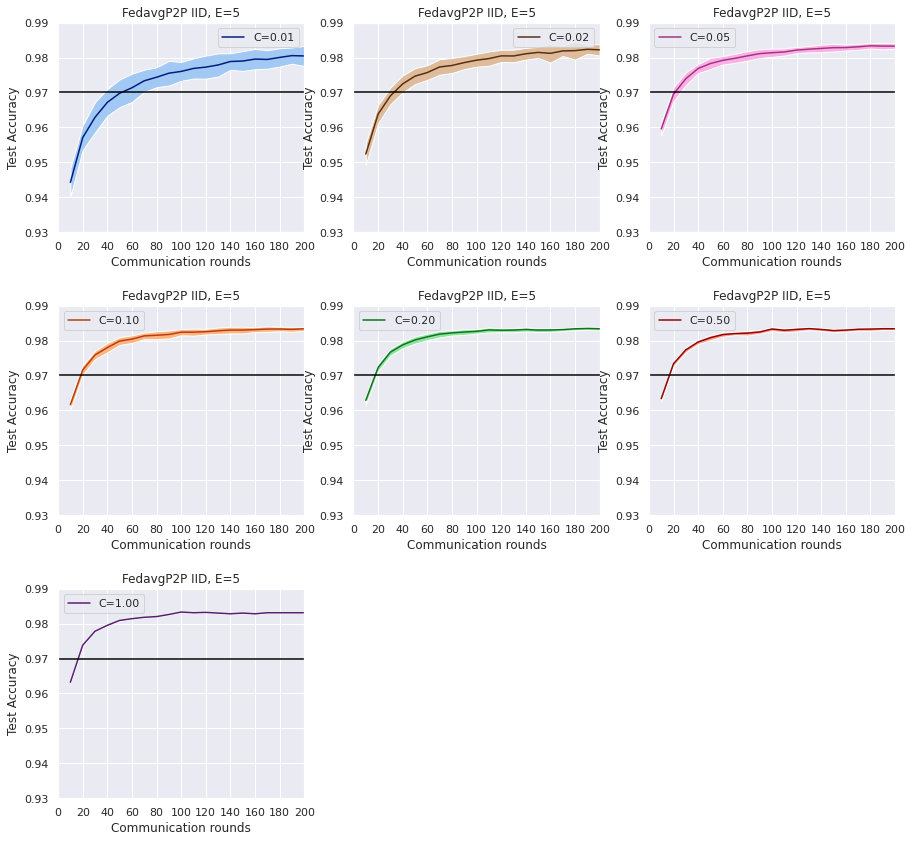

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import matplotlib.ticker as ticker
sns.set_theme(style="darkgrid")
sns.set(rc={'figure.figsize':(15,14.27)})
sns.set(font_scale=1)
fig, ax = plt.subplots(3,3)
fig.subplots_adjust(hspace=0.35)

C_all=[1]
dfs = []
for C in C_all:
    nr_clients = 100 ### NUMBER OF CLIENTS/ENTITIES
    client_epochs = 5   # Number of client epochs
    communication_rounds = 200  # Number of maximum communication rounds
    test_every_x_round = 10

    dir_str = '{}_{}_{}_{}_{}/'.format(nr_clients, C, client_epochs, communication_rounds, test_every_x_round)
    path = './Results/P2P_iid/' + dir_str

    with open(path + 'metrics', 'rb') as metrics_file:
        metrics_p2p = pickle.load(metrics_file)

    # per node communication
    # C*nr_clients*round

    avgs =  [calc_avg_clients_metrics(metrics_p2p[0][i]) for i in range(communication_rounds//test_every_x_round)]
    df_p2p = pd.DataFrame(avgs)
    # make_monotonic('average_accuracy', df_p2p)
    comm_round = [i for i in range(10,210,10)]
    sent_models_per_client = [C*i for i in range(10, 210, 10)]
    # neighbors * communication_round/epoch

    # 0 indexed
    df_p2p['comm_round'] = comm_round
    df_p2p['sent_models_per_client'] = sent_models_per_client
    df_p2p['network_load'] = [i*nr_clients*C for i in range(10, 210, 10)]
    # change columns to match centralized
    df_p2p.columns = ['accuracy', 'precision', 'recall', 'f1','loss', 'upper_2std', 'lower_2std', 'std', 'comm_round', 'sent_models_per_client', 'network_load', ]
    if C == 99:
        dfs.append(df_p2p.assign(Clients="C={}".format(1.0)))
    else:
        dfs.append(df_p2p.assign(Clients="C={}".format(C/100)))

concatenated = pd.concat(dfs)
graph = sns.lineplot(x="comm_round", y="accuracy", hue="Clients", data=concatenated, ax=ax[0][0], palette=[sns.color_palette("dark")[0]])
ax[0][0].fill_between(df_p2p["comm_round"], df_p2p["upper_2std"], df_p2p["lower_2std"], facecolor=sns.color_palette('pastel')[0])
graph.axhline(0.97, color='black')
handles, labels = graph.get_legend_handles_labels()
labels = add_trailing_zeros(labels)
graph.legend(handles=handles[:], labels=labels[:])

ax[0][0].set_xlim(0, 200)
ax[0][0].set_ylim(0.93, 0.99)
graph.xaxis.set_major_locator(ticker.MultipleLocator(20))
graph.set_title('FedavgP2P IID, E=5')
graph.set_xlabel('Communication rounds')
graph.set_ylabel('Test Accuracy')



def plot(C_all, x, y, color, color2):
    dfs = []
    for C in C_all:
        nr_clients = 100 ### NUMBER OF CLIENTS/ENTITIES
        client_epochs = 5   # Number of client epochs
        communication_rounds = 200  # Number of maximum communication rounds
        test_every_x_round = 10

        dir_str = '{}_{}_{}_{}_{}/'.format(nr_clients, C, client_epochs, communication_rounds, test_every_x_round)
        path = './Results/P2P_iid/' + dir_str

        with open(path + 'metrics', 'rb') as metrics_file:
            metrics_p2p = pickle.load(metrics_file)

        # per node communication
        # C*nr_clients*round

        avgs =  [calc_avg_clients_metrics(metrics_p2p[0][i]) for i in range(communication_rounds//test_every_x_round)]
        df_p2p = pd.DataFrame(avgs)
        # make_monotonic('average_accuracy', df_p2p)
        comm_round = [i for i in range(10,210,10)]
        sent_models_per_client = [C*i for i in range(10, 210, 10)]
        # neighbors * communication_round/epoch

        # 0 indexed
        df_p2p['comm_round'] = comm_round
        df_p2p['sent_models_per_client'] = sent_models_per_client
        df_p2p['network_load'] = [i*nr_clients*C for i in range(10, 210, 10)]
        # change columns to match centralized
        df_p2p.columns = ['accuracy', 'precision', 'recall', 'f1','loss', 'upper_2std', 'lower_2std', 'std', 'comm_round', 'sent_models_per_client', 'network_load', ]
        if C == 99:
            dfs.append(df_p2p.assign(Clients="C={}".format(1.0)))
        else:
            dfs.append(df_p2p.assign(Clients="C={}".format(C/100)))

    concatenated = pd.concat(dfs)
    graph = sns.lineplot(x="comm_round", y="accuracy", hue="Clients", data=concatenated, ax=ax[x][y], palette=[color])
    #graph = sns.lineplot(x="comm_round", y="upper_2std", data=concatenated, ax=ax[x][y], color="red")
    #graph = sns.lineplot(x="comm_round", y="lower_2std", data=concatenated, ax=ax[x][y], color="red")
    ax[x][y].fill_between(df_p2p["comm_round"], df_p2p["upper_2std"], df_p2p["lower_2std"], facecolor=color2)
    graph.axhline(0.97, color='black')
    handles, labels = graph.get_legend_handles_labels()
    labels = add_trailing_zeros(labels)
    graph.legend(handles=handles[:], labels=labels[:])

    ax[x][y].set_xlim(0, 200)
    ax[x][y].set_ylim(0.93, 0.99)
    graph.xaxis.set_major_locator(ticker.MultipleLocator(20))
    graph.set_title('FedavgP2P IID, E=5')
    graph.set_xlabel('Communication rounds')
    graph.set_ylabel('Test Accuracy')

plot([2], 0, 1, sns.color_palette("dark")[5] ,sns.color_palette('pastel')[5])
plot([5], 0, 2, sns.color_palette("dark")[6] ,sns.color_palette('pastel')[6])
plot([10], 1, 0,sns.color_palette("dark")[1] ,sns.color_palette('pastel')[1])
plot([20], 1, 1,sns.color_palette("dark")[2] ,sns.color_palette('pastel')[2])
plot([50], 1, 2,sns.color_palette("dark")[3] ,sns.color_palette('pastel')[3])
plot([99], 2, 0,sns.color_palette("dark")[4] ,sns.color_palette('pastel')[4])
ax[2][1].set_visible(False)
ax[2][2].set_visible(False)

fig.savefig("stddeviationiidE5.png")

{'C': [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1], 'sent_models_per_client': [670, 960, 1150, 1600, 2400, 4500, 8910], 'network_load': [67000, 96000, 115000, 160000, 240000, 450000, 891000], 'comm_round': [670, 480, 230, 160, 120, 90, 90]}
{'C': [0.02, 0.05, 0.1, 0.2, 0.5, 1], 'sent_models_per_client': [960, 1150, 1500, 2200, 4500, 8910], 'network_load': [96000, 115000, 150000, 220000, 450000, 891000], 'comm_round': [480, 230, 150, 110, 90, 90]}
{'C': [0.02, 0.05, 0.1, 0.2, 0.5, 1], 'sent_models_per_client': [840, 1000, 1600, 2000, 4500, 7920], 'network_load': [84000, 100000, 160000, 200000, 450000, 792000], 'comm_round': [420, 200, 160, 100, 90, 80]}
{'C': [0.02, 0.05, 0.1, 0.2, 0.5, 1], 'sent_models_per_client': [1600, 3100, 4900, 5800, 4000, 7920], 'network_load': [160000, 310000, 490000, 580000, 400000, 792000], 'comm_round': [800, 620, 490, 290, 80, 80]}


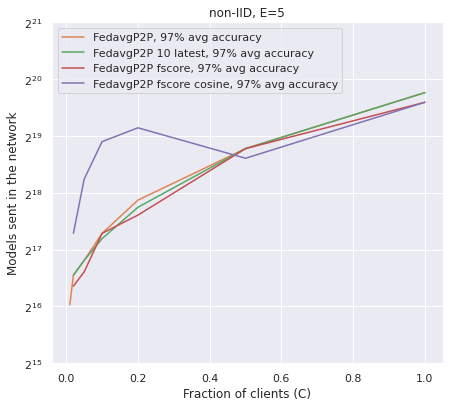

In [62]:
######################################################################

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import matplotlib.ticker as ticker
sns.set_theme(style="darkgrid")
sns.set(rc={'figure.figsize':(7,6.27)})
sns.set(font_scale=1)

dfs = []

reach_threshhold = get_metrics_p2p(5, 1000, False)
print(reach_threshhold)
df = pd.DataFrame(reach_threshhold)
df = df.assign(Alg="FedavgP2P, 97% avg accuracy")
dfs.append(df)
concatenated = pd.concat(dfs)

reach_threshhold = get_metrics_p2p_heur(5, 1000, False)
print(reach_threshhold)
df = pd.DataFrame(reach_threshhold)
df = df.assign(Alg="FedavgP2P 10 latest, 97% avg accuracy")
dfs.append(df)
concatenated = pd.concat(dfs)

reach_threshhold = get_metrics_p2p_acc(5, 1000, False)
print(reach_threshhold)
df = pd.DataFrame(reach_threshhold)
df = df.assign(Alg="FedavgP2P fscore, 97% avg accuracy")
dfs.append(df)
concatenated = pd.concat(dfs)

reach_threshhold = get_metrics_p2p_cos(5, 1000, False)
print(reach_threshhold)
df = pd.DataFrame(reach_threshhold)
df = df.assign(Alg="FedavgP2P fscore cosine, 97% avg accuracy")
dfs.append(df)
concatenated = pd.concat(dfs)

graph = sns.lineplot(x="C", y="network_load", hue="Alg", data=concatenated , palette=['C1', 'C2', 'C3', 'C4'])

graph.set_yscale('log', base=2)
graph.set_ylim(2**15, 2**21)
# Remove legend
handles, labels = graph.get_legend_handles_labels()
graph.legend(handles=handles[:], labels=labels[:])
graph.set_title("non-IID, E=5")
graph.set_ylabel('Models sent in the network')
graph.set_xlabel('Fraction of clients (C)')

fig = graph.get_figure()
fig.savefig("ImprovementAttempts.png")
######################################################################


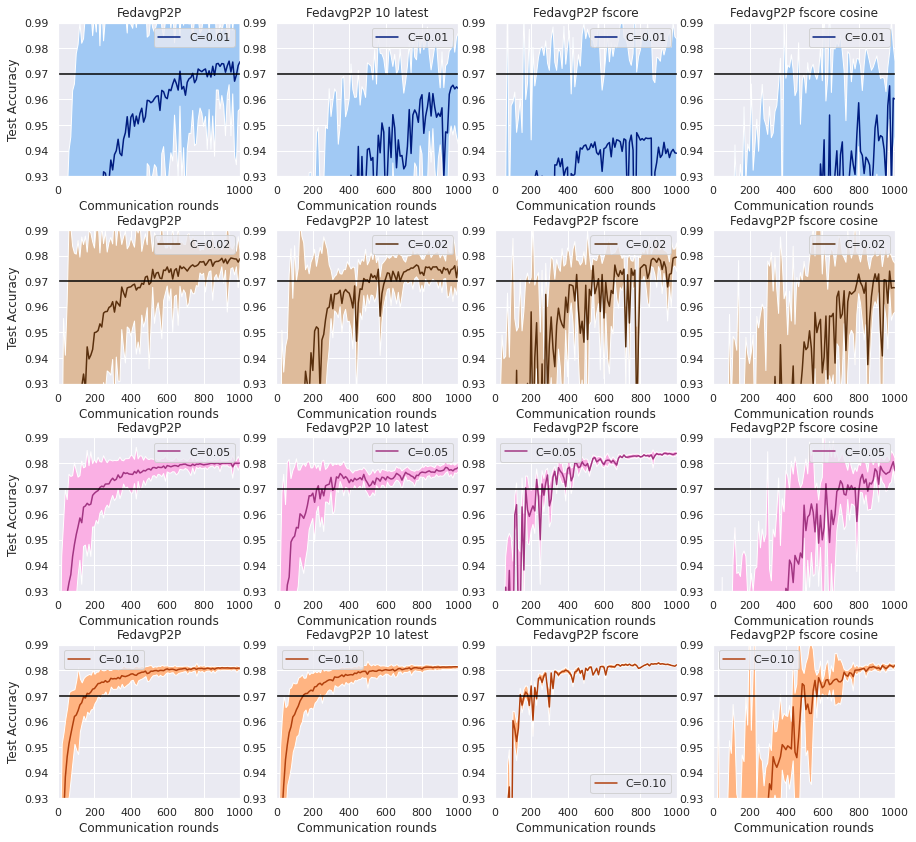

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import matplotlib.ticker as ticker
sns.set_theme(style="darkgrid")
sns.set(rc={'figure.figsize':(15,14.27)})
sns.set(font_scale=1)
fig, ax = plt.subplots(4,4)
fig.subplots_adjust(hspace=0.35)

C_all=[1]
dfs = []
for C in C_all:
    nr_clients = 100 ### NUMBER OF CLIENTS/ENTITIES
    client_epochs = 5   # Number of client epochs
    communication_rounds = 1000  # Number of maximum communication rounds
    test_every_x_round = 10

    dir_str = '{}_{}_{}_{}_{}/'.format(nr_clients, C, client_epochs, communication_rounds, test_every_x_round)
    path = './Results/P2P_non_iid/' + dir_str

    with open(path + 'metrics', 'rb') as metrics_file:
        metrics_p2p = pickle.load(metrics_file)

    # per node communication
    # C*nr_clients*round

    avgs =  [calc_avg_clients_metrics(metrics_p2p[0][i]) for i in range(communication_rounds//test_every_x_round)]
    df_p2p = pd.DataFrame(avgs)
    # make_monotonic('average_accuracy', df_p2p)
    comm_round = [i for i in range(10,1010,10)]
    sent_models_per_client = [C*i for i in range(10, 1010, 10)]
    # neighbors * communication_round/epoch

    # 0 indexed
    df_p2p['comm_round'] = comm_round
    df_p2p['sent_models_per_client'] = sent_models_per_client
    df_p2p['network_load'] = [i*nr_clients*C for i in range(10, 1010, 10)]
    # change columns to match centralized
    df_p2p.columns = ['accuracy', 'precision', 'recall', 'f1','loss', 'upper_2std', 'lower_2std', 'std', 'comm_round', 'sent_models_per_client', 'network_load', ]
    if C == 99:
        dfs.append(df_p2p.assign(Clients="C={}".format(1.0)))
    else:
        dfs.append(df_p2p.assign(Clients="C={}".format(C/100)))

concatenated = pd.concat(dfs)
graph = sns.lineplot(x="comm_round", y="accuracy", hue="Clients", data=concatenated, ax=ax[0][0], palette=[sns.color_palette("dark")[0]])
ax[0][0].fill_between(df_p2p["comm_round"], df_p2p["upper_2std"], df_p2p["lower_2std"], facecolor=sns.color_palette('pastel')[0])
graph.axhline(0.97, color='black')
handles, labels = graph.get_legend_handles_labels()
labels = add_trailing_zeros(labels)
graph.legend(handles=handles[:], labels=labels[:])

ax[0][0].set_xlim(0, 1000)
ax[0][0].set_ylim(0.93, 0.99)
graph.xaxis.set_major_locator(ticker.MultipleLocator(1000))
graph.set_title('FedavgP2P')
graph.set_xlabel('Communication rounds')
graph.set_ylabel('Test Accuracy')



def plot(C_all, x, y, color, color2, results_path, title):
    dfs = []
    for C in C_all:
        nr_clients = 100 ### NUMBER OF CLIENTS/ENTITIES
        client_epochs = 5   # Number of client epochs
        communication_rounds = 1000  # Number of maximum communication rounds
        test_every_x_round = 10

        dir_str = '{}_{}_{}_{}_{}/'.format(nr_clients, C, client_epochs, communication_rounds, test_every_x_round)
        path = results_path + dir_str

        with open(path + 'metrics', 'rb') as metrics_file:
            metrics_p2p = pickle.load(metrics_file)

        # per node communication
        # C*nr_clients*round

        avgs =  [calc_avg_clients_metrics(metrics_p2p[0][i]) for i in range(communication_rounds//test_every_x_round)]
        df_p2p = pd.DataFrame(avgs)
        # make_monotonic('average_accuracy', df_p2p)
        comm_round = [i for i in range(10,1010,10)]
        sent_models_per_client = [C*i for i in range(10, 1010, 10)]
        # neighbors * communication_round/epoch

        # 0 indexed
        df_p2p['comm_round'] = comm_round
        df_p2p['sent_models_per_client'] = sent_models_per_client
        df_p2p['network_load'] = [i*nr_clients*C for i in range(10, 1010, 10)]
        # change columns to match centralized
        df_p2p.columns = ['accuracy', 'precision', 'recall', 'f1','loss', 'upper_2std', 'lower_2std', 'std', 'comm_round', 'sent_models_per_client', 'network_load', ]
        if C == 99:
            dfs.append(df_p2p.assign(Clients="C={}".format(1.0)))
        else:
            dfs.append(df_p2p.assign(Clients="C={}".format(C/100)))

    concatenated = pd.concat(dfs)
    graph = sns.lineplot(x="comm_round", y="accuracy", hue="Clients", data=concatenated, ax=ax[x][y], palette=[color])
    #graph = sns.lineplot(x="comm_round", y="upper_2std", data=concatenated, ax=ax[x][y], color="red")
    #graph = sns.lineplot(x="comm_round", y="lower_2std", data=concatenated, ax=ax[x][y], color="red")
    ax[x][y].fill_between(df_p2p["comm_round"], df_p2p["upper_2std"], df_p2p["lower_2std"], facecolor=color2)
    graph.axhline(0.97, color='black')
    handles, labels = graph.get_legend_handles_labels()
    labels = add_trailing_zeros(labels)
    graph.legend(handles=handles[:], labels=labels[:])

    ax[x][y].set_xlim(0, 1000)
    ax[x][y].set_ylim(0.93, 0.99)
    graph.xaxis.set_major_locator(ticker.MultipleLocator(200))
    graph.set_title(title)
    graph.set_xlabel('Communication rounds')
    if y==0:
        graph.set_ylabel('Test Accuracy')
    else:
        graph.set_ylabel('')

#
plot([2], 1, 0, sns.color_palette("dark")[5] ,sns.color_palette('pastel')[5], './Results/P2P_non_iid/', "FedavgP2P")
plot([5], 2, 0, sns.color_palette("dark")[6] ,sns.color_palette('pastel')[6], './Results/P2P_non_iid/', "FedavgP2P")
plot([10], 3, 0, sns.color_palette("dark")[1] ,sns.color_palette('pastel')[1], './Results/P2P_non_iid/', "FedavgP2P")
#plot([99], 2, 0,sns.color_palette("dark")[4] ,sns.color_palette('pastel')[4], './Results/P2P_non_iid/', "FedavgP2P")

# 10 latest
plot([1], 0, 1, sns.color_palette("dark")[0] ,sns.color_palette('pastel')[0], './Results/P2P_heur_non_iid/', "FedavgP2P 10 latest")
plot([2], 1, 1, sns.color_palette("dark")[5] ,sns.color_palette('pastel')[5], './Results/P2P_heur_non_iid/', "FedavgP2P 10 latest")
plot([5], 2, 1, sns.color_palette("dark")[6] ,sns.color_palette('pastel')[6], './Results/P2P_heur_non_iid/', "FedavgP2P 10 latest")
plot([10], 3, 1, sns.color_palette("dark")[1] ,sns.color_palette('pastel')[1], './Results/P2P_heur_non_iid/', "FedavgP2P 10 latest")
#plot([99], 2, 1, sns.color_palette("dark")[4] ,sns.color_palette('pastel')[4], './Results/P2P_heur_non_iid/', "FedavgP2P 10 latest")

# fscore
plot([1], 0, 2, sns.color_palette("dark")[0] ,sns.color_palette('pastel')[0], './Results/P2P_acc_non_iid_2/', "FedavgP2P fscore")
plot([2], 1, 2, sns.color_palette("dark")[5] ,sns.color_palette('pastel')[5], './Results/P2P_acc_non_iid_2/', "FedavgP2P fscore")
plot([5], 2, 2, sns.color_palette("dark")[6] ,sns.color_palette('pastel')[6], './Results/P2P_acc_non_iid_2/', "FedavgP2P fscore")
plot([10], 3, 2, sns.color_palette("dark")[1] ,sns.color_palette('pastel')[1], './Results/P2P_acc_non_iid_2/', "FedavgP2P fscore")
#plot([99], 2, 2,sns.color_palette("dark")[4] ,sns.color_palette('pastel')[4], './Results/P2P_acc_non_iid_2/', "FedavgP2P fscore")

# fscore cosine
plot([1], 0, 3, sns.color_palette("dark")[0] ,sns.color_palette('pastel')[0], './Results/P2P_cosine_non_iid/', "FedavgP2P fscore cosine")
plot([2], 1, 3, sns.color_palette("dark")[5] ,sns.color_palette('pastel')[5], './Results/P2P_cosine_non_iid/', "FedavgP2P fscore cosine")
plot([5], 2, 3, sns.color_palette("dark")[6] ,sns.color_palette('pastel')[6], './Results/P2P_cosine_non_iid/', "FedavgP2P fscore cosine")
plot([10], 3, 3, sns.color_palette("dark")[1] ,sns.color_palette('pastel')[1], './Results/P2P_cosine_non_iid/', "FedavgP2P fscore cosine")
#plot([99], 2, 3, sns.color_palette("dark")[4] ,sns.color_palette('pastel')[4], './Results/P2P_cosine_non_iid/', "FedavgP2P fscore cosine")

fig.savefig("p2pimprovcompare.png")

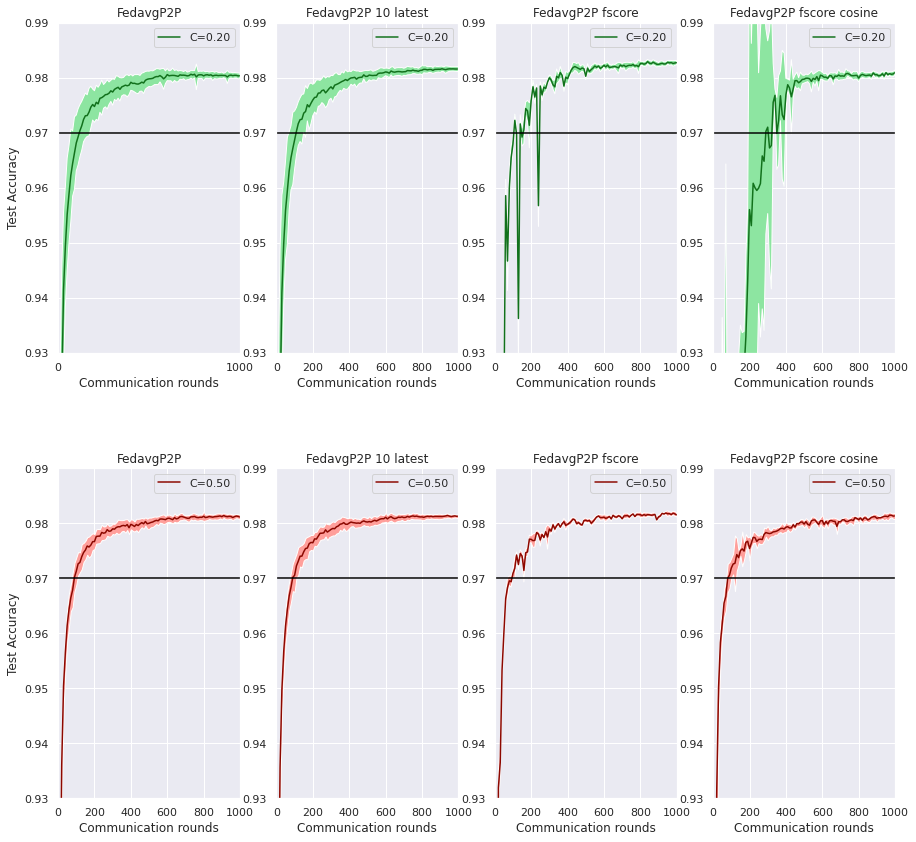

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import matplotlib.ticker as ticker
sns.set_theme(style="darkgrid")
sns.set(rc={'figure.figsize':(15,1.27)})
sns.set(font_scale=1)
fig, ax = plt.subplots(2,4)
fig.subplots_adjust(hspace=0.35)

C_all=[20]
dfs = []
for C in C_all:
    nr_clients = 100 ### NUMBER OF CLIENTS/ENTITIES
    client_epochs = 5   # Number of client epochs
    communication_rounds = 1000  # Number of maximum communication rounds
    test_every_x_round = 10

    dir_str = '{}_{}_{}_{}_{}/'.format(nr_clients, C, client_epochs, communication_rounds, test_every_x_round)
    path = './Results/P2P_non_iid/' + dir_str

    with open(path + 'metrics', 'rb') as metrics_file:
        metrics_p2p = pickle.load(metrics_file)

    # per node communication
    # C*nr_clients*round

    avgs =  [calc_avg_clients_metrics(metrics_p2p[0][i]) for i in range(communication_rounds//test_every_x_round)]
    df_p2p = pd.DataFrame(avgs)
    # make_monotonic('average_accuracy', df_p2p)
    comm_round = [i for i in range(10,1010,10)]
    sent_models_per_client = [C*i for i in range(10, 1010, 10)]
    # neighbors * communication_round/epoch

    # 0 indexed
    df_p2p['comm_round'] = comm_round
    df_p2p['sent_models_per_client'] = sent_models_per_client
    df_p2p['network_load'] = [i*nr_clients*C for i in range(10, 1010, 10)]
    # change columns to match centralized
    df_p2p.columns = ['accuracy', 'precision', 'recall', 'f1','loss', 'upper_2std', 'lower_2std', 'std', 'comm_round', 'sent_models_per_client', 'network_load', ]
    if C == 99:
        dfs.append(df_p2p.assign(Clients="C={}".format(1.0)))
    else:
        dfs.append(df_p2p.assign(Clients="C={}".format(C/100)))

concatenated = pd.concat(dfs)
graph = sns.lineplot(x="comm_round", y="accuracy", hue="Clients", data=concatenated, ax=ax[0][0], palette=[sns.color_palette("dark")[2]])
ax[0][0].fill_between(df_p2p["comm_round"], df_p2p["upper_2std"], df_p2p["lower_2std"], facecolor=sns.color_palette('pastel')[2])
graph.axhline(0.97, color='black')
handles, labels = graph.get_legend_handles_labels()
labels = add_trailing_zeros(labels)
graph.legend(handles=handles[:], labels=labels[:])

ax[0][0].set_xlim(0, 1000)
ax[0][0].set_ylim(0.93, 0.99)
graph.xaxis.set_major_locator(ticker.MultipleLocator(1000))
graph.set_title('FedavgP2P')
graph.set_xlabel('Communication rounds')
graph.set_ylabel('Test Accuracy')



def plot(C_all, x, y, color, color2, results_path, title):
    dfs = []
    for C in C_all:
        nr_clients = 100 ### NUMBER OF CLIENTS/ENTITIES
        client_epochs = 5   # Number of client epochs
        communication_rounds = 1000  # Number of maximum communication rounds
        test_every_x_round = 10

        dir_str = '{}_{}_{}_{}_{}/'.format(nr_clients, C, client_epochs, communication_rounds, test_every_x_round)
        path = results_path + dir_str

        with open(path + 'metrics', 'rb') as metrics_file:
            metrics_p2p = pickle.load(metrics_file)

        # per node communication
        # C*nr_clients*round

        avgs =  [calc_avg_clients_metrics(metrics_p2p[0][i]) for i in range(communication_rounds//test_every_x_round)]
        df_p2p = pd.DataFrame(avgs)
        # make_monotonic('average_accuracy', df_p2p)
        comm_round = [i for i in range(10,1010,10)]
        sent_models_per_client = [C*i for i in range(10, 1010, 10)]
        # neighbors * communication_round/epoch

        # 0 indexed
        df_p2p['comm_round'] = comm_round
        df_p2p['sent_models_per_client'] = sent_models_per_client
        df_p2p['network_load'] = [i*nr_clients*C for i in range(10, 1010, 10)]
        # change columns to match centralized
        df_p2p.columns = ['accuracy', 'precision', 'recall', 'f1','loss', 'upper_2std', 'lower_2std', 'std', 'comm_round', 'sent_models_per_client', 'network_load', ]
        if C == 99:
            dfs.append(df_p2p.assign(Clients="C={}".format(1.0)))
        else:
            dfs.append(df_p2p.assign(Clients="C={}".format(C/100)))

    concatenated = pd.concat(dfs)
    graph = sns.lineplot(x="comm_round", y="accuracy", hue="Clients", data=concatenated, ax=ax[x][y], palette=[color])
    #graph = sns.lineplot(x="comm_round", y="upper_2std", data=concatenated, ax=ax[x][y], color="red")
    #graph = sns.lineplot(x="comm_round", y="lower_2std", data=concatenated, ax=ax[x][y], color="red")
    ax[x][y].fill_between(df_p2p["comm_round"], df_p2p["upper_2std"], df_p2p["lower_2std"], facecolor=color2)
    graph.axhline(0.97, color='black')
    handles, labels = graph.get_legend_handles_labels()
    labels = add_trailing_zeros(labels)
    graph.legend(handles=handles[:], labels=labels[:])

    ax[x][y].set_xlim(0, 1000)
    ax[x][y].set_ylim(0.93, 0.99)
    graph.xaxis.set_major_locator(ticker.MultipleLocator(200))
    graph.set_title(title)
    graph.set_xlabel('Communication rounds')
    if y==0:
        graph.set_ylabel('Test Accuracy')
    else:
        graph.set_ylabel('')

#
plot([50], 1, 0, sns.color_palette("dark")[3] ,sns.color_palette('pastel')[3], './Results/P2P_non_iid/', "FedavgP2P")
#plot([99], 2, 0,sns.color_palette("dark")[4] ,sns.color_palette('pastel')[4], './Results/P2P_non_iid/', "FedavgP2P")

# 10 latest
plot([20], 0, 1, sns.color_palette("dark")[2] ,sns.color_palette('pastel')[2], './Results/P2P_heur_non_iid/', "FedavgP2P 10 latest")
plot([50], 1, 1, sns.color_palette("dark")[3] ,sns.color_palette('pastel')[3], './Results/P2P_heur_non_iid/', "FedavgP2P 10 latest")
#plot([99], 2, 1, sns.color_palette("dark")[4] ,sns.color_palette('pastel')[4], './Results/P2P_heur_non_iid/', "FedavgP2P 10 latest")

# fscore
plot([20], 0, 2, sns.color_palette("dark")[2] ,sns.color_palette('pastel')[2], './Results/P2P_acc_non_iid_2/', "FedavgP2P fscore")
plot([50], 1, 2, sns.color_palette("dark")[3] ,sns.color_palette('pastel')[3], './Results/P2P_acc_non_iid_2/', "FedavgP2P fscore")
#plot([99], 2, 2,sns.color_palette("dark")[4] ,sns.color_palette('pastel')[4], './Results/P2P_acc_non_iid_2/', "FedavgP2P fscore")

# fscore cosine
plot([20], 0, 3, sns.color_palette("dark")[2] ,sns.color_palette('pastel')[2], './Results/P2P_cosine_non_iid/', "FedavgP2P fscore cosine")
plot([50], 1, 3, sns.color_palette("dark")[3] ,sns.color_palette('pastel')[3], './Results/P2P_cosine_non_iid/', "FedavgP2P fscore cosine")
#plot([99], 2, 3, sns.color_palette("dark")[4] ,sns.color_palette('pastel')[4], './Results/P2P_cosine_non_iid/', "FedavgP2P fscore cosine")


fig.savefig("p2pimprovcompare2.png")